# Reinforcement Learning for crypto portfolio allocation 

## Table Of Contents :
1. [Data collection and EDA](#1)
    1. [Data collection](#1sub1)
        * [One time API request](#1sub1sub1)
        * [Loop API request](#1sub1sub2)

    2. [EDA](#1sub2)
        * [Missing Values](#1sub2sub1)
        * [Static Statistics Table](#1sub2sub2)
        * [Dynamic Statistics Table](#1sub2sub3)
        * [Time-series Price Plot](#1sub2sub4)
        * [Time-series Cumulative Returns Plot](#1sub2sub5)
        * [Correlation Matrix](#1sub2sub6)
        * [Rolling Correlation Matrix](#1sub2sub7)
        * [Boxplot](#1sub2sub8)


2. [Modeling](#2)
    1. [Pytorch Lightning formulation](#2sub1)
        * [Dataset creation](#2sub1sub1)
        * [Model definition](#2sub1sub2)
        

    2. [Synthetic data](#2sub2)
        * [Noisy Trends](#2sub2sub1)
        * [Noisy Periodic](#2sub2sub2)
        * [Noisy Seasonal Trends](#2sub2sub3)
    3. [Model Training and Evaluation](#2sub3)
        * [Model Training](#2sub3sub1)
        * [Benchmark and Backtest Preparation](#2sub3sub2)    
        * [Model Evaluation](#2sub3sub3)    
        * [Test TS training](#2sub3sub4)    
        * [Test Initial Assumptions](#2sub3sub5)    


## 1. Data collection and EDA <a class="anchor" id="1"></a>

### 1.1. Data Collection <a class="anchor" id="1sub1"></a>

- Data is collected from major central exchange (Binance) to avoid any missing values and low volumes.

- We pre-select a range of cryptocurrencies from the top 10 by market cap these crypto currencies have long recorded trading history and high historic volumes alongside BTC

- The OHLC data is collected by 30 min interval

- market data is collected on pairs against BTC since BTC will be considered as the cash asset (risk-free return in a crypto-only portfolio)

In [7]:
import numpy as np
import pandas as pd
import math
import os
import requests
import warnings
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import matplotlib.gridspec as gridspec
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.stattools as st
import statsmodels.stats.diagnostic as ss

from scipy.stats import skew, kurtosis, jarque_bera, levy_stable

from arch import arch_model
from arch.univariate.base import ConvergenceWarning

from hurst import compute_Hc

from tqdm import tqdm
from PIL import Image

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

CUDA_LAUNCH_BLOCKING = 1.
import lightning as L
import mlflow
import torch
from lightning.pytorch.loggers import MLFlowLogger
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from NBEATS import NBEATS
from Run_RL import LModel


sns.set_theme(context='notebook', style='white')
Coinlist = ['ADA', 'ETH', 'LINK', 'LTC', 'XRP', 'BNB', 'DOGE', 'TRX']

In [2]:
base = "https://api.binance.com/api/v3/klines"
pairs = ["BTCUSDT", "ADABTC","ETHBTC","LINKBTC","LTCBTC","XRPBTC", "DOGEBTC","BNBBTC","SOLBTC","TRXBTC"]
# pairs = [
#     "ETHBTC", "XRPBTC", "BNBBTC", "SOLBTC", "DOGEBTC", 
#     "ADABTC", "TRXBTC", "LINKBTC", "AVAXBTC", "XLMBTC", 
#     "BCHBTC", "LTCBTC", "DOTBTC", "XMRBTC", "UNIBTC", 
#     "NEARBTC", "AAVEBTC", "ETCBTC", "ICPBTC"
#     ]

#### One Time API Request <a class="anchor" id="1sub1sub1"></a>

In [4]:
interval = "30m"    # 1s, 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
limit = 1000

raw_frames = []
for s in pairs:
    r = requests.get(base, params={"symbol": s, "interval": interval, "limit": limit}, timeout=10)
    r.raise_for_status()
    cols = ["open_time", "open", "high", "low", "close", "volume", "close_time", "quote_volume", "trades", "taker_base_vol", "taker_quote_vol", "ignore"]
    df = pd.DataFrame(r.json(), columns=cols)
    df[cols] = df[cols].astype(float)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    df["symbol"] = s
    raw_frames.append(df)

data = pd.concat(raw_frames, ignore_index=True)

data["open_time"] = data["open_time"].dt.strftime("%Y-%m-%d %H:%M")
data = data.set_index("open_time")

data_open = data.pivot(columns="symbol", values="open")
data_high = data.pivot(columns="symbol", values="high")
data_low = data.pivot(columns="symbol", values="low")
data_close = data.pivot(columns="symbol", values="close")
data_volume = data.pivot(columns="symbol", values="volume")
data_quote_volume = data.pivot(columns="symbol", values="quote_volume")
data_trades = data.pivot(columns="symbol", values="trades")
data_taker_base_vol = data.pivot(columns="symbol", values="taker_base_vol")
data_taker_quote_vol = data.pivot(columns="symbol", values="taker_quote_vol")
data_ignore = data.pivot(columns="symbol", values="ignore")

#### Loop API Request  <a class="anchor" id="1sub1sub2"></a>

In [5]:
interval = "30m"    # 1s, 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
limit = 1000

start_date = datetime(2020, 1, 1)
end_date = datetime(2025, 4, 1)

raw_frames = []

for s in tqdm(pairs):
    current = start_date
    while current < end_date:
        start_ms = int(current.timestamp() * 1000)
        next_current = current + timedelta(minutes=30 * limit)
        end_ms = int(next_current.timestamp() * 1000)

        r = requests.get(base, params={"symbol": s, "interval": interval, "limit": limit, "startTime": start_ms, "endTime": end_ms}, timeout=10)
        r.raise_for_status()
        raw_data = r.json()

        if not raw_data:
            current = next_current
            continue

        cols = ["open_time", "open", "high", "low", "close", "volume", "close_time", "quote_volume", "trades", "taker_base_vol", "taker_quote_vol", "ignore"]
        df = pd.DataFrame(raw_data, columns=cols)
        df[cols] = df[cols].astype(float)
        df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
        df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
        df["symbol"] = s
        raw_frames.append(df)

        current = pd.to_datetime(raw_data[-1][0], unit="ms") + timedelta(minutes=30)

100%|██████████| 10/10 [05:39<00:00, 33.98s/it]


In [6]:
new_raw_frames = [df for df in raw_frames if df["symbol"].iloc[0] in pairs]

data = pd.concat(new_raw_frames, ignore_index=True)
data = data.drop_duplicates(subset=["open_time", "symbol"], keep="first")
data["open_time"] = pd.to_datetime(data["open_time"])
data = data.set_index(["open_time", "symbol"])

data_open = data["open"].unstack(level="symbol").reindex(columns=pairs)
data_high = data["high"].unstack(level="symbol").reindex(columns=pairs)
data_low = data["low"].unstack(level="symbol").reindex(columns=pairs)
data_close = data["close"].unstack(level="symbol").reindex(columns=pairs)
data_volume = data["volume"].unstack(level="symbol").reindex(columns=pairs)
data_quote_volume = data["quote_volume"].unstack(level="symbol").reindex(columns=pairs)
data_trades = data["trades"].unstack(level="symbol").reindex(columns=pairs)
data_taker_base_vol = data["taker_base_vol"].unstack(level="symbol").reindex(columns=pairs)
data_taker_quote_vol = data["taker_quote_vol"].unstack(level="symbol").reindex(columns=pairs)
data_ignore = data["ignore"].unstack(level="symbol").reindex(columns=pairs)

data_returns = (np.log(data_close) - np.log(data_close.shift(1))).iloc[1:, :].reindex(columns=pairs)

In [43]:
timestamp = datetime.now().strftime("%Y%m%d")
path = f"{timestamp} Request Data"
os.makedirs(path, exist_ok=True)

data_open.to_csv(f"{path}/data_open.csv", encoding="utf-8", index_label="Time")
data_high.to_csv(f"{path}/data_high.csv", encoding="utf-8", index_label="Time")
data_low.to_csv(f"{path}/data_low.csv", encoding="utf-8", index_label="Time")
data_close.to_csv(f"{path}/data_close.csv", encoding="utf-8", index_label="Time")
data_volume.to_csv(f"{path}/data_volume.csv", encoding="utf-8", index_label="Time")
data_quote_volume.to_csv(f"{path}/data_quote_volume.csv", encoding="utf-8", index_label="Time")
data_trades.to_csv(f"{path}/data_trades.csv", encoding="utf-8", index_label="Time")
data_taker_base_vol.to_csv(f"{path}/data_taker_base_vol.csv", encoding="utf-8", index_label="Time")
data_taker_quote_vol.to_csv(f"{path}/data_taker_quote_vol.csv", encoding="utf-8", index_label="Time")
data_ignore.to_csv(f"{path}/data_ignore.csv", encoding="utf-8", index_label="Time")
data_returns.to_csv(f"{path}/data_returns.csv", encoding="utf-8", index_label="Time")

#### Create dataset <a class="anchor" id="1sub1sub3"></a>

- The data, collected in one dataframe will then converted to a torch tensor of shape (features, coins, time) for training

In [113]:
close = pd.read_csv('20250528 Request Data/data_close.csv')
low = pd.read_csv('20250528 Request Data/data_low.csv')
high = pd.read_csv('20250528 Request Data/data_high.csv')
close['Time'] = pd.to_datetime(close['Time'])
low['Time'] = pd.to_datetime(low['Time'])
high['Time'] = pd.to_datetime(high['Time'])

In [15]:
Coinlist = ['ADA', 'ETH', 'LINK', 'LTC', 'XRP', 'BNB', 'DOGE', 'TRX']

In [27]:
df_all = pd.merge(high, low, on='Time', suffixes=('_high', '_low'))
df_all = pd.merge(df_all, close, on='Time', suffixes=('', '_high'))
df_all = df_all[[f'{a}BTC'+f for a in Coinlist for f in ['','_low','_high']]]

In [ ]:
df_all.to_parquet('./data/df_all.parquet') # Collected data is saved as parquet for easy loading

### 1.2. EDA<a class="anchor" id="1sub2"></a>

In [45]:
path = "EDA"
os.makedirs(path, exist_ok=True)

#### Missing Values <a class="anchor" id="1sub2sub1"></a>

In [30]:
data.isna().sum()

open               0
high               0
low                0
close              0
volume             0
close_time         0
quote_volume       0
trades             0
taker_base_vol     0
taker_quote_vol    0
ignore             0
dtype: int64

- Data from Binance does not have missing values at 30 min interval ( since considered time period is recent years)

#### Static Statistics Table <a class="anchor" id="1sub2sub2"></a>

In [31]:
stats_rows = []
for col in data_returns.columns:
    x = data_returns[col].dropna()
    
    jb_stat, jb_p = jarque_bera(x)
    sig = '***' if jb_p<0.01 else '**' if jb_p<0.05 else '*' if jb_p<0.1 else ''
    
    eq_curve = np.exp(x.cumsum())
    roll_max = eq_curve.cummax()
    max_dd = ((eq_curve / roll_max) - 1).min()
    
    acf1 = sm.tsa.acf(x, nlags=1, fft=False)[1] if len(x) > 1 else np.nan
    hurst = compute_Hc(x, kind="change", simplified=False)[0] if len(x) >= 20 else np.nan
    
    stats_rows.append([
        f"{x.mean():.5f}",
        f"{x.std():.4f}",
        f"{skew(x):.4f}",
        f"{kurtosis(x):.4f}",
        f"{x.min():.4f}",
        f"{x.median():.4f}",
        f"{x.max():.4f}",
        f"{jb_stat:.2f}{sig}",
        f"{max_dd:.2%}",
        f"{acf1:.4f}",
        f"{hurst:.4f}"
    ])

stats_df = pd.DataFrame(stats_rows, columns=["Mean","Std","Skew","Kurt","Min","50%","Max","JB","MDD","ACF(1)","Hurst"], index=data_returns.columns)

display(stats_df)

,Mean,Std,Skew,Kurt,Min,50%,Max,JB,MDD,ACF(1),Hurst
symbol,,,,,,,,,,,
BTCUSDT,0.00003,0.0050,-0.7448,61.0404,-0.1819,0.0000,0.1363,14437080.13***,-77.20%,-0.0192,0.5495
ADABTC,0.00000,0.0061,0.4744,42.4178,-0.1535,0.0000,0.1481,6971095.91***,-92.47%,-0.0411,0.5495
ETHBTC,0.00000,0.0034,0.1611,26.7294,-0.0919,0.0000,0.0714,2767115.86***,-79.52%,-0.0036,0.5406
LINKBTC,-0.00001,0.0064,0.0130,28.4719,-0.1586,0.0000,0.1204,3139213.54***,-91.88%,-0.0340,0.5280
LTCBTC,-0.00002,0.0051,0.2741,73.8493,-0.2016,0.0000,0.1836,21120462.32***,-89.82%,-0.0695,0.4989
XRPBTC,-0.00000,0.0066,0.8806,95.7947,-0.2036,0.0000,0.2367,35548140.11***,-84.22%,-0.0214,0.5227
DOGEBTC,0.00002,0.0158,0.4253,25.7229,-0.3365,0.0000,0.4238,2565085.93***,-87.46%,-0.3386,0.5258
BNBBTC,0.00001,0.0046,0.1968,40.0944,-0.1083,0.0000,0.1119,6225811.47***,-72.84%,-0.0234,0.5687
SOLBTC,0.00003,0.0088,0.8575,33.8448,-0.1648,-0.0001,0.2411,4217825.72***,-89.18%,-0.0375,0.5605


#### Dynamic Statistics Table <a class="anchor" id="1sub2sub3"></a>

In [32]:
adf_stat, adf_p = [], []
lb_stat, lb_p   = [], []
lb2_stat, lb2_p = [], []
lm_stat, lm_p   = [], []

for col in data_returns.columns:
    x = data_returns[col].dropna()
    
    res_adf = st.adfuller(x); adf_stat.append(res_adf[0]); adf_p.append(res_adf[1])
    
    res_lb  = ss.acorr_ljungbox(x, lags=[10])
    lb_stat.append(res_lb.lb_stat.iloc[-1]); lb_p.append(res_lb.lb_pvalue.iloc[-1])
    
    res_lb2 = ss.acorr_ljungbox(x**2, lags=[10])
    lb2_stat.append(res_lb2.lb_stat.iloc[-1]); lb2_p.append(res_lb2.lb_pvalue.iloc[-1])
    
    res_lm  = ss.acorr_lm(x, nlags=10)
    lm_stat.append(res_lm[0]); lm_p.append(res_lm[1])

dynamic_df = pd.DataFrame({
    "ADF": [f"{s:.2f}{'***' if p<0.01 else '**' if p<0.05 else '*' if p<0.1 else ''}" for s,p in zip(adf_stat, adf_p)],
    "LB":  [f"{s:.2f}{'***' if p<0.01 else '**' if p<0.05 else '*' if p<0.1 else ''}" for s,p in zip(lb_stat, lb_p)],
    "LB2": [f"{s:.2f}{'***' if p<0.01 else '**' if p<0.05 else '*' if p<0.1 else ''}" for s,p in zip(lb2_stat, lb2_p)],
    "LM":  [f"{s:.2f}{'***' if p<0.01 else '**' if p<0.05 else '*' if p<0.1 else ''}" for s,p in zip(lm_stat, lm_p)]
}, index=data_returns.columns)

display(dynamic_df)

,ADF,LB,LB2,LM
symbol,,,,
BTCUSDT,-39.02***,133.34***,12447.14***,134.68***
ADABTC,-41.53***,254.55***,15878.58***,263.81***
ETHBTC,-41.25***,32.65***,10232.18***,32.85***
LINKBTC,-37.26***,186.75***,10321.01***,195.25***
LTCBTC,-43.87***,514.56***,5824.21***,542.63***
XRPBTC,-36.65***,185.46***,15890.84***,188.50***
DOGEBTC,-39.72***,10751.53***,69486.70***,12919.50***
BNBBTC,-37.56***,103.14***,25514.03***,106.38***
SOLBTC,-37.81***,248.67***,15071.54***,250.53***


In [33]:
stats_df.to_csv(f"{path}/Static Statistics.csv")
dynamic_df.to_csv(f"{path}/Dynamic Statistics.csv")

#### Time-series Price Plot <a class="anchor" id="1sub2sub4"></a>

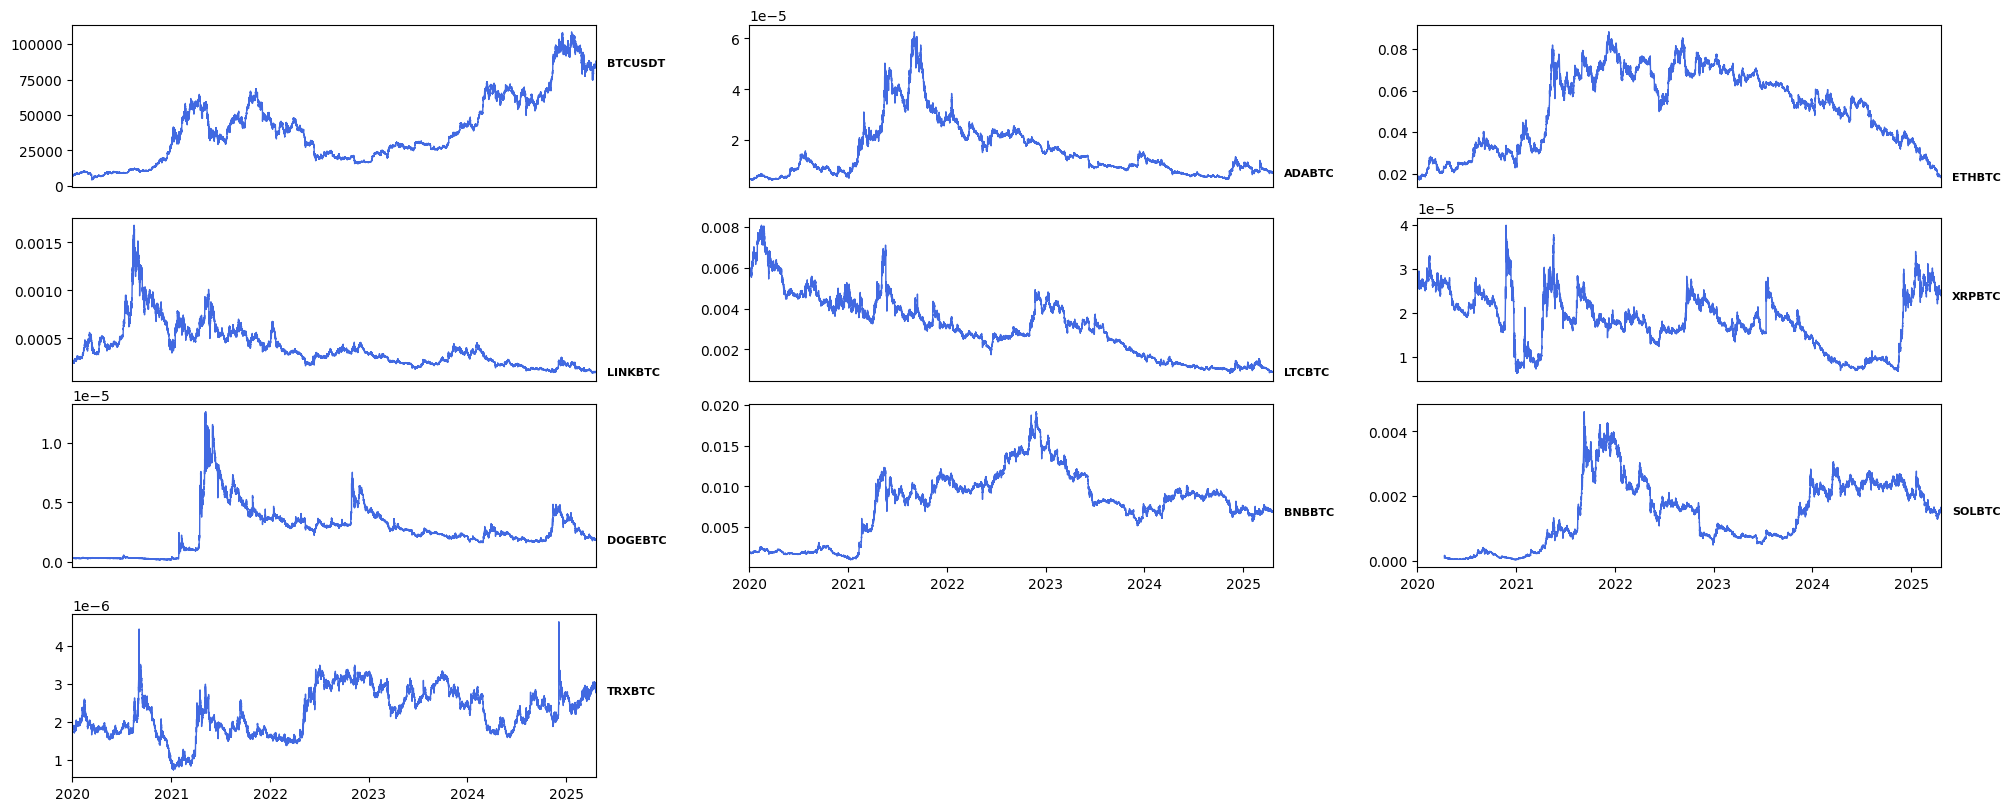

In [34]:
n_assets = len(data_close.columns)
n_cols = 3
n_rows = (n_assets + n_cols - 1) // n_cols

fig = plt.figure(figsize=(20, 2 * n_rows), constrained_layout=True)
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, wspace=0.05, hspace=0)

axes = []

for i in range(n_assets):
    row = i // n_cols
    col = i % n_cols
    ax = fig.add_subplot(gs[row, col])
    coin = data_close.columns[i]
    ax.plot(data_close.index, data_close[coin], linewidth=1, color='royalblue')
    ax.text(data_close[coin].dropna().index[-1] + timedelta(days=40), data_close[coin].dropna().iloc[-1], coin, fontsize=8, fontweight='bold', va='center')
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xlim(data_close.index[0], data_close.index[-1])
    ax.yaxis.set_tick_params(labelsize=10)
    axes.append(ax)
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

last_row_indices = list(range(n_assets - n_cols, n_assets))
for idx, ax in enumerate(axes):
    if idx not in last_row_indices:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.savefig(f'{path}/Price TS.png', dpi=144, transparent=True)
plt.show()

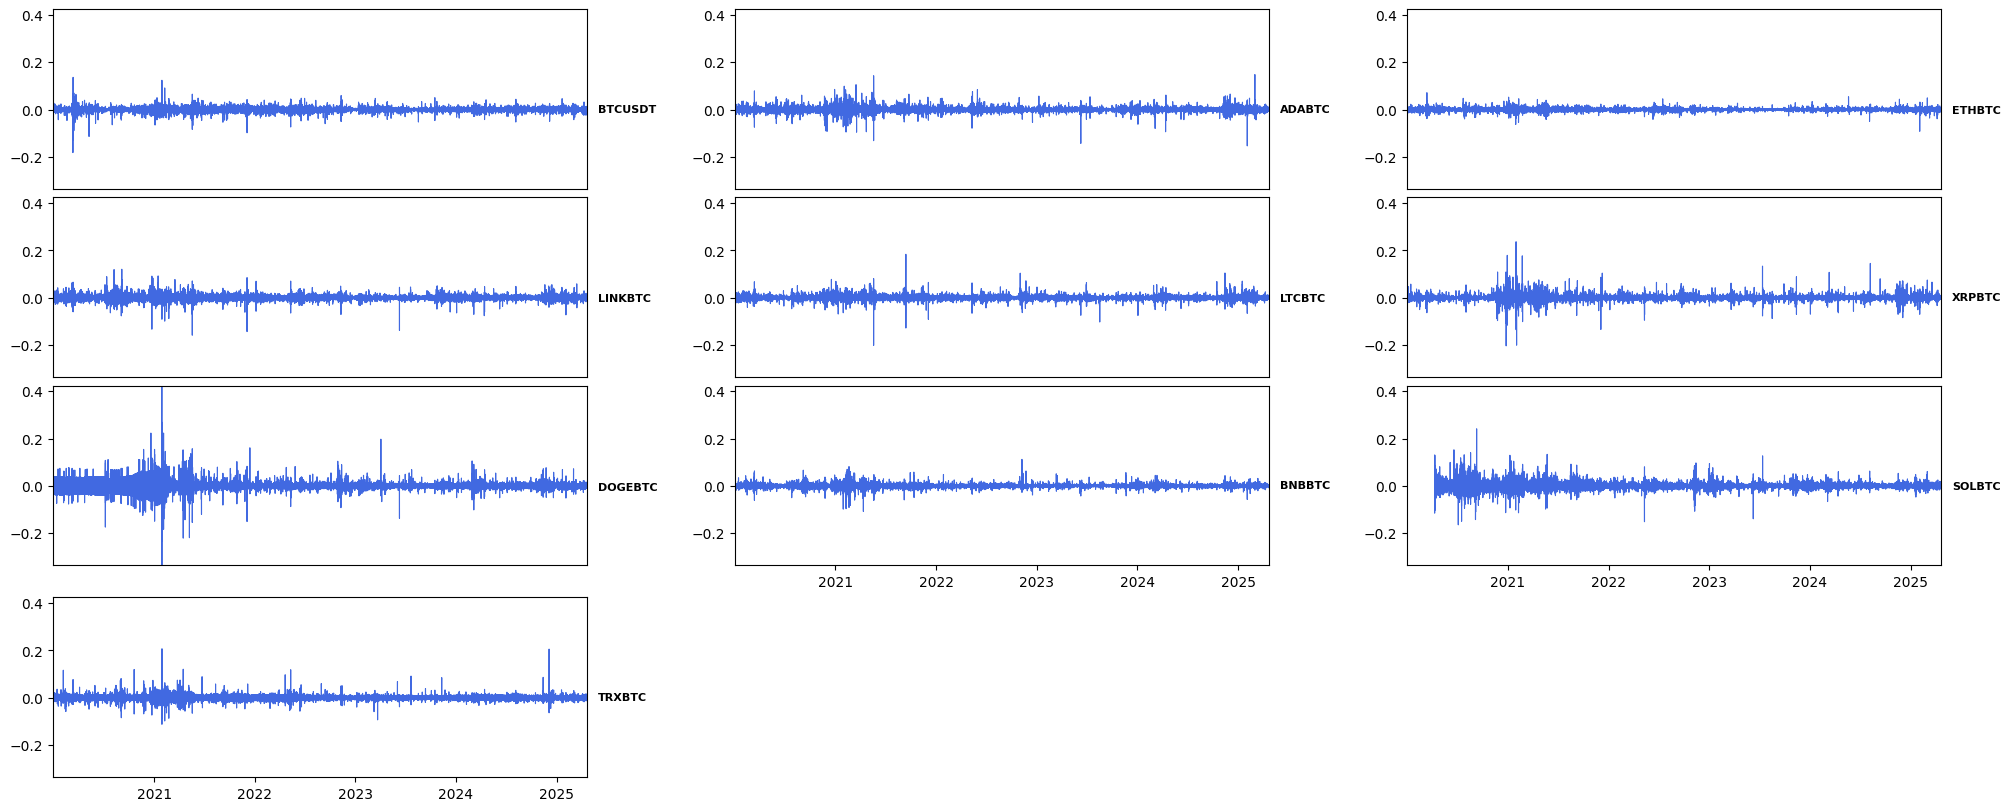

In [35]:
n_assets = len(data_returns.columns)
n_cols = 3
n_rows = (n_assets + n_cols - 1) // n_cols

fig = plt.figure(figsize=(20, 2 * n_rows), constrained_layout=True)
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, wspace=0.05, hspace=0)

axes = []

for i in range(n_assets):
    row = i // n_cols
    col = i % n_cols
    ax = fig.add_subplot(gs[row, col])
    coin = data_returns.columns[i]
    ax.plot(data_returns.index, data_returns[coin], linewidth=0.8, color='royalblue')
    ax.text(data_returns[coin].dropna().index[-1] + timedelta(days=40), data_returns[coin].dropna().iloc[-1], coin, fontsize=8, fontweight='bold', va='center')
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xlim(data_returns.index[0], data_returns.index[-1])
    ax.set_ylim(data_returns.min().min(), data_returns.max().max())
    ax.yaxis.set_tick_params(labelsize=10)
    axes.append(ax)

for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

last_row_indices = list(range(n_assets - n_cols, n_assets))
for idx, ax in enumerate(axes):
    if idx not in last_row_indices:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.savefig(f'{path}/Returns TS.png', dpi=144, transparent=True)
plt.show()

#### Time-series Cumulative Returns Plot <a class="anchor" id="1sub2sub5"></a>

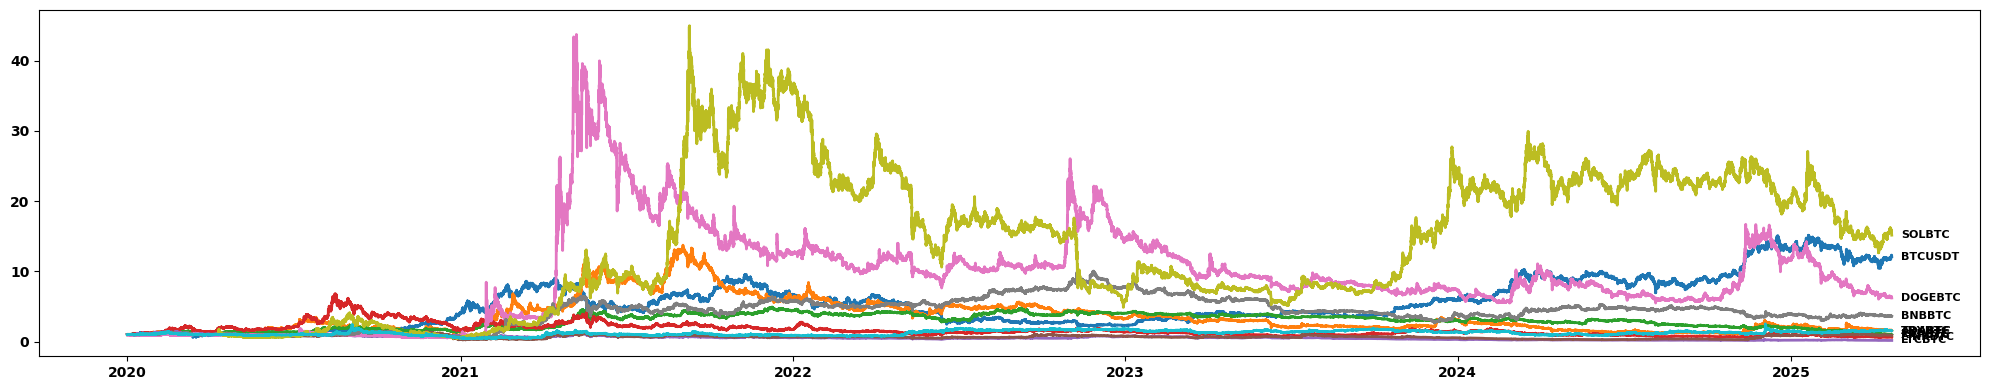

In [36]:
norm_close = data_close.copy()
for coin in norm_close.columns:
    norm_close[coin] = norm_close[coin] / norm_close[coin].dropna().iloc[0]

plt.figure(figsize=(20, 4))
for coin in norm_close.columns:
    plt.plot(norm_close[coin], linewidth=2)
    plt.text(norm_close[coin].dropna().index[-1] + timedelta(days=10), norm_close[coin].dropna().iloc[-1], coin, fontsize=8, fontweight='bold', va='center')
plt.xticks(fontsize=10, fontweight='heavy')
plt.yticks(fontsize=10, fontweight='heavy')
plt.tight_layout()
plt.savefig(f'{path}/Cum Returns TS.png', dpi=144, transparent=True)
plt.show()

#### Correlation Matrix <a class="anchor" id="1sub2sub6"></a>

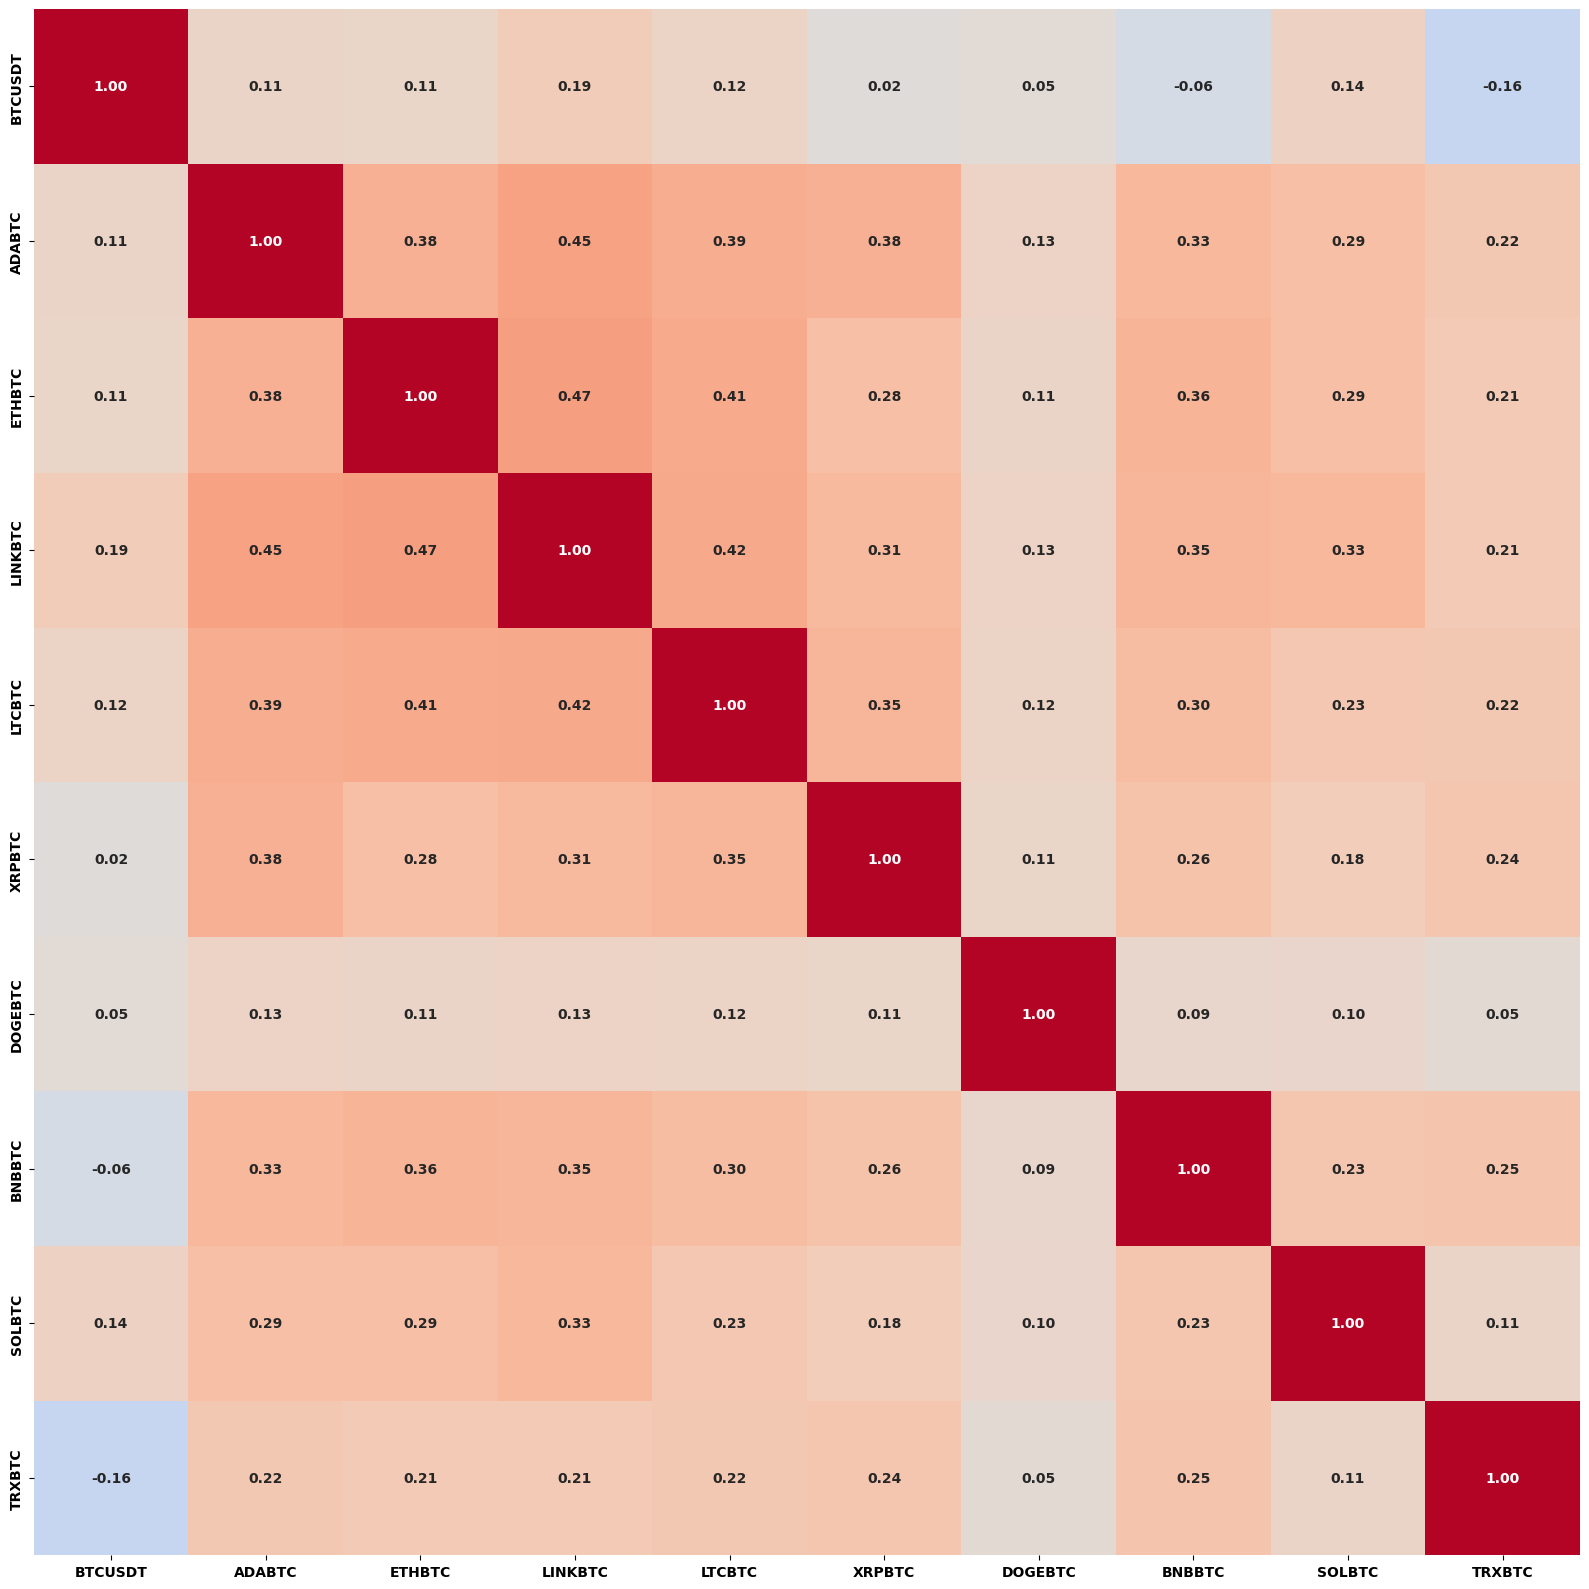

In [37]:
corr = data_returns.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr,annot=True,fmt=".2f", vmin=-1, vmax=1,cmap="coolwarm", square=True, cbar=False, annot_kws={"weight": "bold"})
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=0, fontsize=10, fontweight='heavy')
plt.yticks(fontsize=10, fontweight='heavy')
plt.tight_layout()
plt.savefig(f'{path}/Correlation Matrix.png', dpi=144, transparent=True)
plt.show()

- Among all pairs indexed on BTC, DOGE stands out as the most uncorellated : explained by high volatility which is highly dependent on random events (news etc..)

<Figure size 2000x1600 with 0 Axes>

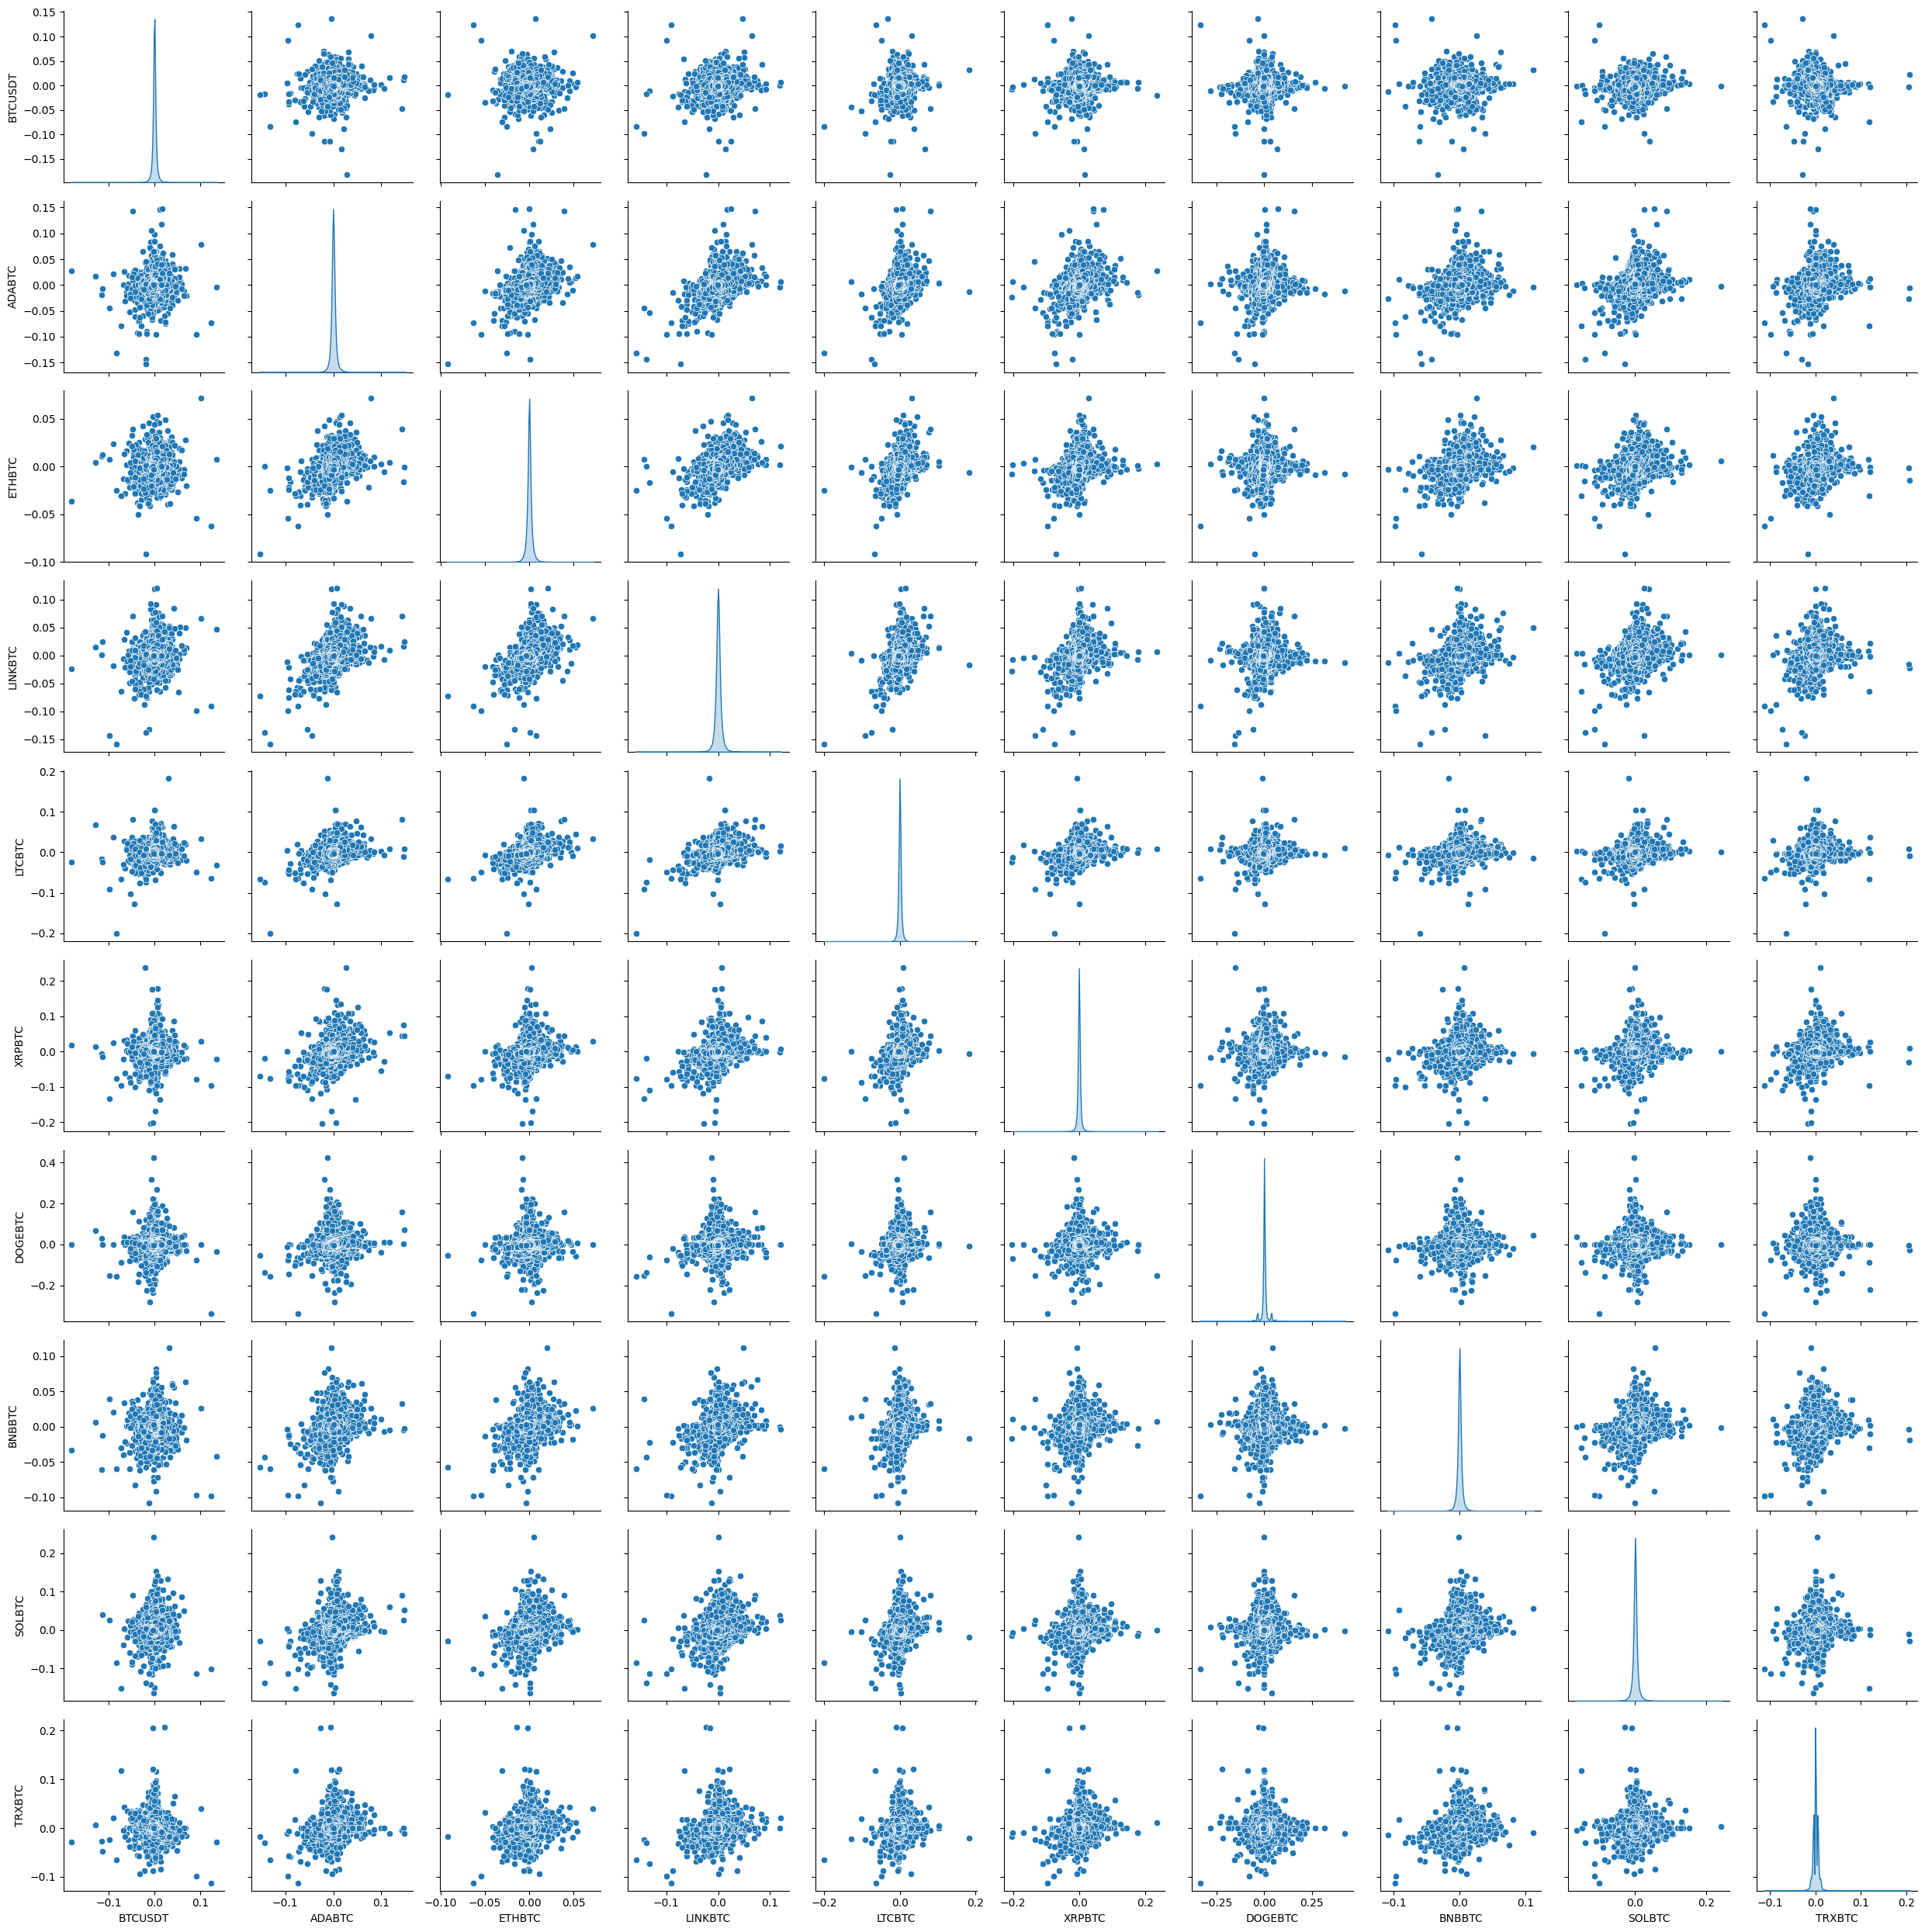

In [38]:
plt.figure(figsize=(20, 16))
sns.pairplot(data_returns, diag_kind="kde")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=30, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(f'{path}/Pair Plot.png', dpi=144, transparent=True)
plt.show()

#### Rolling Correlation Matrix <a class="anchor" id="1sub2sub7"></a>

- Applying rolling correlation show asset correlation grows when market is bullish 

In [40]:
index = pd.read_csv("Import Data/Cryptocurrency LargeCap Index.csv", index_col=0, parse_dates=True)

In [41]:
pathname = f"{path}/Rolling Correlation Matrix"
os.makedirs(pathname, exist_ok=True)

window = 5760  # 1 Quarter
step = 1440    # 1 Month
step_daily = 48

images = []
rolling_corr_df = pd.DataFrame()
rolling_corr_avg = []

for i in tqdm(range(0, len(data_returns)-window+1, step_daily), desc="Calculating Rolling Correlation Summary"):
    temp_df = data_returns.iloc[i:i+window]
    corr_mat = temp_df.corr()
    sum_corr = (corr_mat.sum().sum() - corr_mat.shape[0]) / 2
    temp_df = pd.DataFrame({'Date': temp_df.index[-1], 'Correlation': sum_corr}, index=[0])
    rolling_corr_df = pd.concat([rolling_corr_df, temp_df], ignore_index=True)

    corr_mat_mask = np.triu(np.ones_like(corr_mat, dtype=bool), k=1)
    temp_avg = corr_mat.where(corr_mat_mask).stack().mean()
    rolling_corr_avg.append({'Date': temp_df.iloc[0, 0], 'Average': temp_avg})

rolling_corr_df['Date'] = pd.to_datetime(rolling_corr_df['Date'])
rolling_corr_df.set_index('Date', inplace=True)

rolling_corr_avg = pd.DataFrame(rolling_corr_avg)
rolling_corr_avg.set_index('Date', inplace=True)

for i in tqdm(range(0, len(data_returns)-window+1, step), desc="Generating Heatmaps"):
    start_idx = i
    end_idx = i + window
    rolling_start = data_returns.index[start_idx]
    rolling_end = data_returns.index[end_idx - 1]

    roll_corr = data_returns.iloc[start_idx:end_idx].corr()

    fig = plt.figure(figsize=(10, 14))
    gs = gridspec.GridSpec(5, 1, height_ratios=[25, 2, 4.5, 4.5, 0.5])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[2])
    ax3 = fig.add_subplot(gs[3], sharex=ax2)
    ax4 = fig.add_subplot(gs[4], sharex=ax2)

    mask = np.triu(np.ones_like(roll_corr, dtype=bool))
    cmap = 'bwr'
    sns.heatmap(roll_corr, cmap=cmap, center=0, annot=False, fmt=".2f", mask=mask, vmin=-1, vmax=1, ax=ax1, square=True, cbar=False)
    ax1.set_xlabel("")
    ax1.set_ylabel("")

    ax2.plot(index, color='royalblue', linewidth=2)
    ax2.set_xlim(data_returns.index[0], data_returns.index[-1])
    ax2.set_title('S&P Cryptocurrency LargeCap Index', fontsize=10, fontweight='heavy')
    ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # ax3.plot(rolling_corr_df)
    ax3.plot(rolling_corr_avg, color='royalblue', linewidth=2)
    ax3.set_ylim(rolling_corr_avg.min(axis=0).iloc[0] - 0.05, rolling_corr_avg.max(axis=0).iloc[0] + 0.05)
    ax3.set_xlim(data_returns.index[0], data_returns.index[-1])
    ax3.xaxis.set_major_locator(mdates.YearLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax3.set_title('Rolling Average Correlation', fontsize=10, fontweight='heavy')

    rolling_start_num = date2num(rolling_start)
    rolling_end_num = date2num(rolling_end)
    ax4.broken_barh([(rolling_start_num, rolling_end_num - rolling_start_num)], (0, 1), facecolors='royalblue')
    ax4.set_xlim(data_returns.index[0], data_returns.index[-1])
    ax4.set_ylim(0, 1)
    ax4.get_yaxis().set_visible(False)
    ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    for ax in [ax2, ax3, ax4]:
        ax.axvline(x=rolling_end_num, color='crimson', linestyle='--')

    fig.suptitle(f"{rolling_start.strftime('%Y-%m-%d')} to {rolling_end.strftime('%Y-%m-%d')} Rolling Correlation Heatmap", fontsize=16, fontweight='bold', y=0.94)
    img_path = f"{pathname}/{rolling_start.strftime('%Y%m%d')}_{rolling_end.strftime('%Y%m%d')}.png"
    plt.savefig(img_path, transparent=True, dpi=144)
    plt.close()

Calculating Rolling Correlation Summary:   0%|          | 0/1817 [00:00<?, ?it/s]

Generating Heatmaps: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


In [42]:
png_files = sorted([os.path.join(pathname, f) for f in os.listdir(pathname) if f.endswith('.png')])
frames = []

for png_file in png_files:
    img = Image.open(png_file).convert("RGBA")
    alpha = img.getchannel("A")
    img = img.convert("RGB").convert("P", palette=Image.ADAPTIVE, colors=256, dither=Image.NONE)
    transparency = 255
    for x in range(img.width):
        for y in range(img.height):
            if alpha.getpixel((x, y)) == 0:
                transparency = img.getpixel((x, y))
                break
        if transparency != 255:
            break
    frames.append(img)

frames[0].save(f'{pathname}/Rolling Correlation Matrix.gif',save_all=True, append_images=frames[1:], duration=150, loop=0, transparency=transparency, disposal=2, optimize=False)

#### Boxplot <a class="anchor" id="1sub2sub8"></a>

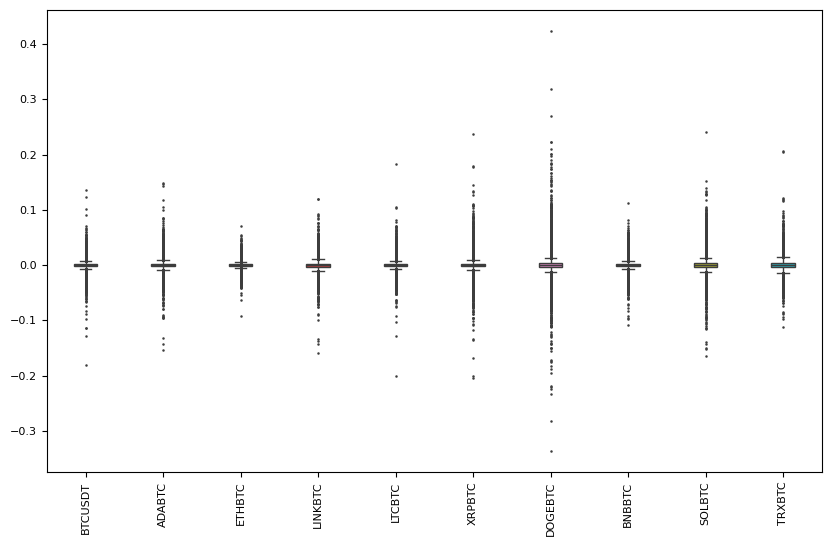

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_returns, width=0.3, fliersize=0.8, linewidth=1)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("")
plt.ylabel("")
plt.savefig(f'{path}/Boxplot.png', dpi=144, transparent=True)
plt.show()

- DOGE is by far the most volatile asset

## 2. Modeling <a class="anchor" id="2"></a>

### 2.1 Pytorch Lightning formulation <a class="anchor" id="2sub1"></a>

- Modeling is done using  pytorch lightning API
- Naive modeling can be written similarly to a supervised learning problem :
    - Without transaction fees, we can use a simple mapping dataset with no need for experience buffer
    - in the case of transaction fees, a buffer is needed to update last_weight in the loss computation, dataset is then iterable with geometric sampling to help converge both the model and the values stored in the buffer
- Training is always done with validation set and a patience setting to monitor model performance
- Benchmark policies from :  [OLPS github](github.com/OLPS/OLPS)

#### Dataset Creation <a class="anchor" id="2sub1sub1"></a>

In [16]:
class Data_portfolio(Dataset):
    def __init__(self, flag, input_len, split, assets):
        super().__init__()
        self.flag = flag
        self.input_len = input_len
        self.split = split
        self.assets = assets
        self.__read_data__()

    def __read_data__(self):
        data = self.assets
        data = torch.tensor(data)
        data = torch.permute(data, (2,1,0))
        self.split_test = self.split + 1/2*(1-self.split)
        self.split = int(self.split * data.shape[-1])
        
        self.test_split = int(self.split_test*data.shape[-1])
        if self.flag == 'train':
            self.data = data[:,:,:self.split]
        elif self.flag == 'val':
            self.data = data[:,:,self.split:self.test_split]
        elif self.flag == 'test':
            self.data = data[:,:,self.test_split:]
    def __getitem__(self, index):  
        seq_x =self.data[:,:,index:index+self.input_len]
        seq_x = seq_x
        ### Use returns

        seq_y = self.data[0,:,index+self.input_len]/self.data[0,:,index+self.input_len-1]
        seq_y = torch.cat((torch.tensor([1]), seq_y), dim = 0)
        return seq_x, seq_y
    
    def __len__(self):
        return self.data.shape[-1]-self.input_len-1

In [17]:
class DataModule_noval(L.LightningDataModule):
    def __init__(self, input_len, split, batch_size, assets):
        self.split = split
        self.batch_size = batch_size
        self.input_len = input_len
        self.assets = assets
        super().__init__()
        # self.save_hyperparameters()
    def setup(self, stage : str):
        if stage == 'fit' :
            self.dataset_train = Data_portfolio( flag = 'train', input_len=self.input_len, split = self.split, assets = self.assets)
            self.dataset_val = Data_portfolio( flag = 'val', input_len=self.input_len, split = self.split, assets = self.assets)
        if stage == 'test' :
            self.dataset_test = Data_portfolio(flag = 'test', input_len=self.input_len, split = self.split, assets = self.assets)
        
    def train_dataloader(self):
        return DataLoader(
        self.dataset_train,
        batch_size = self.batch_size,
        shuffle = True,
        num_workers = 3,
        drop_last = True)
    
    def val_dataloader(self):
        return DataLoader(
        self.dataset_val,
        batch_size = self.batch_size,
        shuffle = False,
        num_workers = 3,
        drop_last = True)
        
    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, shuffle=False, num_workers=2, drop_last = True)

#### Model definition  <a class="anchor" id="2sub1sub2"></a>

In [18]:
class Model(nn.Module):
    def __init__(self, seq_len, batch_size):
        super(Model, self).__init__()
        self.layer = 3
        self.seq_len = seq_len
        self.conv = nn.Conv2d(in_channels=1, out_channels = 2, kernel_size=(1,3), stride = 1, padding = 'valid')
        self.dropout = nn.Dropout2d(0.5)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=20, kernel_size=(1,seq_len-2), stride = 1, padding = 'valid')
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=1, kernel_size=1, padding = 'valid')
        self.last_activ = nn.Softmax(dim = 1)
        self.dense = nn.Linear(11,12)

            
    def forward(self, x):
        self.means = x.mean(-1, keepdim=True).detach()
        x = x - self.means
        self.stdev = torch.sqrt(torch.var(x, dim=-1, keepdim=True, unbiased=False) + 1e-5)
        x /= self.stdev
        
        x = self.conv(x)
        x = self.relu(x) 
        x =self.dropout(x)

        x = self.conv2(x)
        x = self.relu(x)
        x =self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        x = self.last_activ(x)
        return x


def var_init(model, std=0.5):
    for name, param in model.named_parameters():
        param.data.normal_(mean=0.0, std=0.5)


In [19]:
class LModel(L.LightningModule):
    def __init__(self, seq_len, batch_size):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.lr = 1e-4
        self.model =  Model(seq_len = seq_len, batch_size=batch_size)
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        batch_x, batch_y = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        outputs = self.model(batch_x)
        # outputs = torch.concatenate()
        loss = torch.mean(torch.log(torch.sum(outputs*batch_y, dim = 1)))
        APV = torch.exp(torch.sum(torch.log(torch.sum(outputs*batch_y, dim = 1))))
        pv =  torch.sum(outputs * batch_y, dim = 1)
        sharpe_ratio = (torch.mean(pv)-1)/torch.std(pv)
        self.log('train_loss', loss, on_epoch = True)
        self.log('train_sharpe', sharpe_ratio)
        
        return loss 

    def validation_step(self, batch, batch_idx):
        batch_x, batch_y = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        outputs = self.model(batch_x)
        loss = torch.mean(torch.log(torch.sum(outputs*batch_y, dim = 1)))
        APV = torch.exp(torch.sum(torch.log(torch.sum(outputs*batch_y, dim = 1))))
        pv =  torch.sum(outputs * batch_y, dim = 1)
        sharpe_ratio = (torch.mean(pv)-1)/torch.std(pv)
        self.log('val_loss', loss)
        self.log('val_APV', APV)
        self.log('val_sharpe', sharpe_ratio)
        
        
    def test_step(self, batch, batch_idx):
        batch_x, batch_y = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        outputs = self.model(batch_x)
        reward = torch.mean(torch.log(torch.sum(outputs*batch_y, dim = 1)))
        APV = torch.exp(torch.sum(torch.log(torch.sum(outputs*batch_y, dim = 1))))
        pv =  torch.sum(outputs * batch_y, dim = 1)
        sharpe_ratio = (torch.mean(pv)-1)/torch.std(pv)
        self.log('test_reward', reward)
        self.log('test_APV', APV)
        self.log('test_sharpe', sharpe_ratio)
    def forward(self, x):
        return self.model(x)
            
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, maximize = True)
        return optimizer


### 2.2 Synthetic Data <a class="anchor" id="2sub2"></a>

#### Noisy Trends <a class="anchor" id="2sub2sub1"></a>

In [46]:
N = 5000

trend = lambda x : np.arange(0,N)*x + N 
noise = lambda eps : np.random.normal(0, eps, N)

In [47]:
slopes = np.random.uniform(-0.5, 0.5, size = (11,))

assets = []
for s in slopes:
    asset = trend(s) + noise(5)
    assets.append(asset)
assets = np.array(assets).T
assets = np.expand_dims(assets, axis = -1)

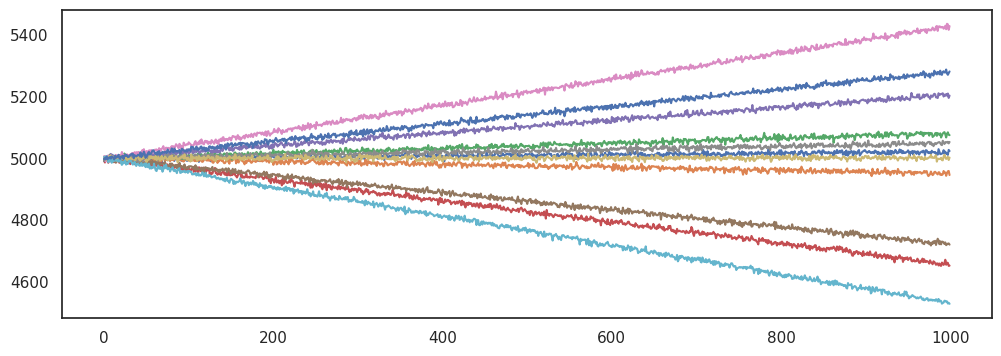

In [48]:
plt.figure(figsize = (12,4))
for a in range(11):
    plt.plot(assets[:1000,a])
    plt.savefig('trendnoise.png', dpi = 200, transparent = True)

In [49]:
Lmodel = LModel(seq_len=50, batch_size=200)
data = DataModule_noval(input_len = 50, split= 0.7, batch_size = 200, assets = assets)

In [ ]:
n_epochs = 500
trainer = L.Trainer(
                    devices = 1, accelerator = 'gpu',  max_epochs = n_epochs, log_every_n_steps=n_epochs//10, enable_progress_bar=True, 
                    callbacks=[EarlyStopping('val_loss', patience=20, mode='max'), ModelCheckpoint(dirpath = f'Noisy_trends',filename='best_model', save_top_k=1, mode='max')])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [51]:
trainer.fit(Lmodel, data)
trainer.test(Lmodel, data)

/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/jovyan/cloned_gits/RL_project/Noisy_trends exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | Model | 2.1 K  | train
----------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 61: 100%|██████████| 17/17 [00:00<00:00, 30.23it/s, v_num=95e7]
🏃 View run RL_run_synth at: https://mlflow-public.models.cardoai.com/#/experiments/2815/runs/ce45c54bc7e240cba7f90dfce97295e7
🧪 View experiment at: https://mlflow-public.models.cardoai.com/#/experiments/2815


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 48.78it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_APV          │    1.0117907524108887     │
│        test_reward        │   5.860167948412709e-05   │
│        test_sharpe        │   0.057619813829660416    │
└───────────────────────────┴───────────────────────────┘

🏃 View run RL_run_synth at: https://mlflow-public.models.cardoai.com/#/experiments/2815/runs/ce45c54bc7e240cba7f90dfce97295e7
🧪 View experiment at: https://mlflow-public.models.cardoai.com/#/experiments/2815


[{'test_reward': 5.860167948412709e-05,
  'test_APV': 1.0117907524108887,
  'test_sharpe': 0.057619813829660416}]

In [2]:
def simplex_proj(y):
    '''projection of y onto simplex. '''
    m = len(y)
    bget = False

    s = torch.sort(y, descending = True)[0]
    tmpsum = 0.

    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1)
        if tmax >= s[ii+1]:
            bget = True
            break

    if not bget:
        tmax = (tmpsum + s[m-1] - 1) / m

    return torch.maximum(torch.tensor(0), y-tmax)

## Define strategies
class buy_and_hold():
    def __init__(self, n):
        self.n = n
    def __call__(self, x, lastw = None):
        new_w = torch.zeros((12)).to('cuda:0')
        new_w[self.n] = 1
        return new_w.unsqueeze(0)

class UCRP():
    def __init__(self):
        pass
    
    def __call__(self, x, lastw = None):
        new_w = torch.ones((12)).to('cuda:0')
        new_w = new_w/torch.sum(new_w)
        return new_w.unsqueeze(0)

class PAMR():
    def __init__(self, epsilon, variant, C):
        self.epsilon = epsilon
        self.C = torch.tensor(C)
        self.variant = variant

    def __call__(self, x, lastw):
        last_rel_price = x[0,-1,:,-1]/x[0,-1,:,-2]
        last_rel_price = torch.cat((torch.tensor([1]).to('cuda:0'), last_rel_price), dim = 0)
        lastw = torch.cat((torch.tensor([1-torch.sum(lastw)]).to('cuda:0'), lastw.squeeze()), dim = 0)

        denom = torch.square(torch.norm(last_rel_price-torch.mean(last_rel_price)))
        diff = torch.dot(lastw.float(), last_rel_price.squeeze().float())- self.epsilon
        le = torch.maximum(torch.tensor(0), diff)

        if self.variant == 0:
            tau = le / denom
        elif self.variant == 1:
            tau = torch.minimum(self.C, le / denom)
        elif self.variant == 2:
            tau = le / (denom + 0.5 / self.C)
            
        tau = torch.minimum(torch.tensor(10000), tau)

        new_w = lastw - tau * (last_rel_price - torch.mean(last_rel_price))
        return simplex_proj(new_w).unsqueeze(0)
        

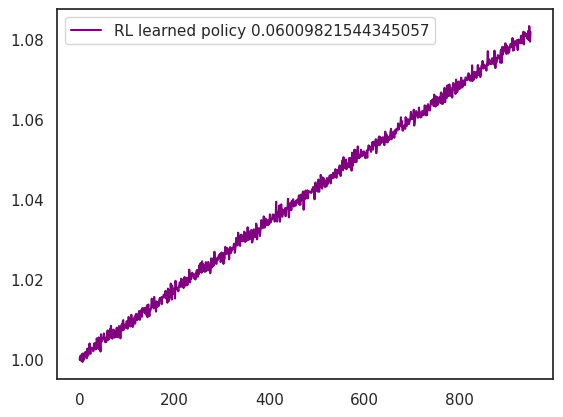

In [ ]:
model = LModel.load_from_checkpoint('Noisy_trends/best_model.ckpt')

# model = LModel.load_from_checkpoint()

data = assets
data = torch.tensor(data)
backtest = torch.permute(data, (2,1,0))
def backtest_by_strategy(data, strategy, seq_len, last_w = False):
    # lastw = torch.zeros((7))
    # lastw[0] = 1
    lastw = torch.ones((12))/12
    lastw = lastw.unsqueeze(0).to('cuda:0')
    log_mean =[]
    APV = [1]
    pvector = []
    w = []
    Y = []
    for i in range(1000-seq_len):
        x = data[:,:,i:i+seq_len]/ data[0,:,i+seq_len:i+seq_len+1].repeat((1,1,seq_len))
        y = (data[0,:,i+seq_len]/data[0,:,i+seq_len-1])
        y = torch.cat((torch.tensor([1]), y), dim = 0).to('cuda:0')
        if last_w:        
            new_w = strategy(x.unsqueeze(0).to('cuda:0'), lastw[:,1:].to('cuda:0'))
        else:
            new_w = strategy(x.unsqueeze(0).to('cuda:0').float())
        w.append(np.array(new_w.squeeze().cpu().detach()))
        Y.append(np.array(y.cpu().detach()))
        w_prime = (y * lastw).to('cuda:0')
        w_prime = w_prime/torch.sum(w_prime)
        c = 0.0
        mu = 1 - torch.sum(torch.abs(new_w - w_prime), dim=1) * c
        pv = torch.sum(new_w * y.to('cuda:0') * mu.to('cuda:0'))
        pvector.append(pv)
        log_mean.append(torch.mean(torch.log(torch.sum(new_w * y.to('cuda:0') * mu.to('cuda:0')))).item())
        APV.append(APV[-1]*torch.exp(torch.tensor(log_mean[-1])))
        lastw = new_w
    return APV, log_mean, torch.tensor(pvector), w, Y
model.eval()
APV, log_mean, pv, w, Y = backtest_by_strategy(backtest, model, model.seq_len, False)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'purple', label = f'RL learned policy {sharpe}')
plt.legend()

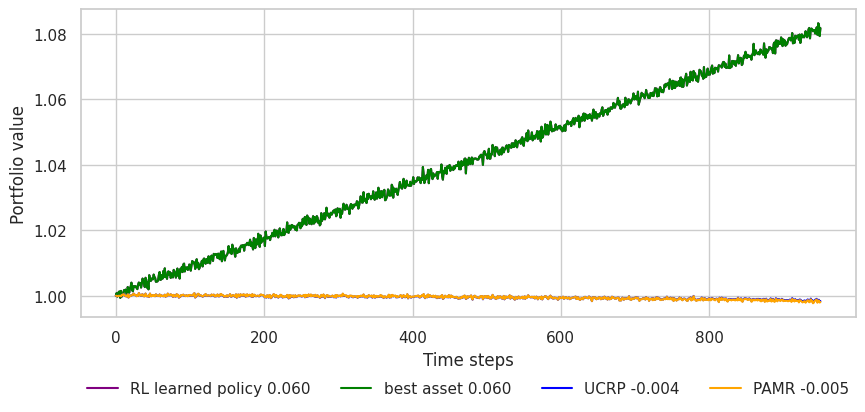

In [54]:
model.eval()
sns.set_style('whitegrid')
plt.figure(figsize=(10,4))
APV, log_mean, pv, w, _ = backtest_by_strategy(backtest, model, model.seq_len, False)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'purple', label = f'RL learned policy {sharpe:.3f}')
APV, log_mean, pv, _, _ = backtest_by_strategy(backtest, buy_and_hold(np.argmax(slopes) + 1), model.seq_len)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'green', label = f'best asset {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, UCRP(), model.seq_len)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'blue', label = f'UCRP {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, PAMR(0.95, 2, 0.5), model.seq_len, True)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'orange', label = f'PAMR {sharpe:.3f}')
plt.xlabel('Time steps')
plt.ylabel('Portfolio value')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 7, frameon = False)
plt.savefig('APV_plot_model',dpi = 300, transparent = True,  bbox_inches="tight")

/tmp/ipykernel_19755/2702963712.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


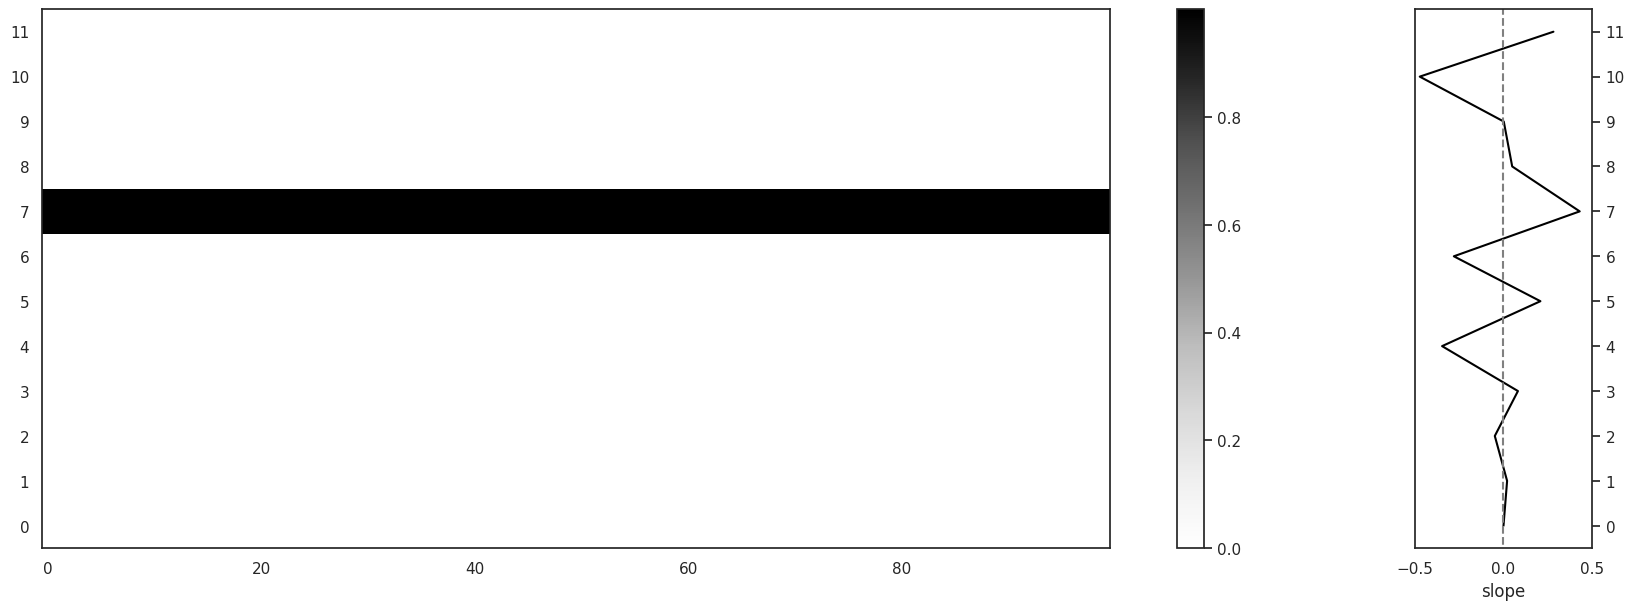

In [55]:
import matplotlib.gridspec as gridspec
sns.set_style('white')
fig = plt.figure(figsize = (20,7))
gs = gridspec.GridSpec(1, 2, width_ratios=[15, 2], wspace=0.05)
# Create second axes sharing the y-axis, positioned to the right
ax_matrix = fig.add_subplot(gs[0])
im = ax_matrix.imshow(np.array(w)[:100].T, cmap=plt.cm.Greys, aspect = 'auto')
plt.colorbar(im, ax = ax_matrix)

ax_curve = fig.add_subplot(gs[1], sharey=ax_matrix)
ax_curve.plot([0] + list(slopes), np.arange(np.array(w).shape[1]), color = 'black')

ax_curve.vlines(0, -2, 15, linestyles= '--', color ='grey')
ax_curve.set_ylim(-0.5,11.5)
ax_curve.set_xlim(-0.5,.5)
ax_curve.set_xlabel("Mean Value")
ax_curve.yaxis.tick_right()
ax_curve.yaxis.set_label_position("right")
ax_curve.set_xlabel('slope')
plt.yticks(range(12))
plt.tight_layout()

plt.savefig('weights_distrib_noise5_lr3',dpi = 300, transparent = True)

> Model converges to holding only asset with highest slope

#### Noisy periodic  <a class="anchor" id="2sub2sub2"></a>

In [56]:
N = 5000

trend = lambda x : np.sin((np.arange(N)+N/10*x)/(20*np.pi)) * N/100+ N 
noise = lambda eps : np.random.normal(0, eps, N)

In [57]:
slopes = np.random.uniform(0, 100, size = (11,))

assets = []
for s in slopes:
    asset = trend(s) + noise(50)
    assets.append(asset)
assets = np.array(assets).T
assets = np.expand_dims(assets, axis = -1)

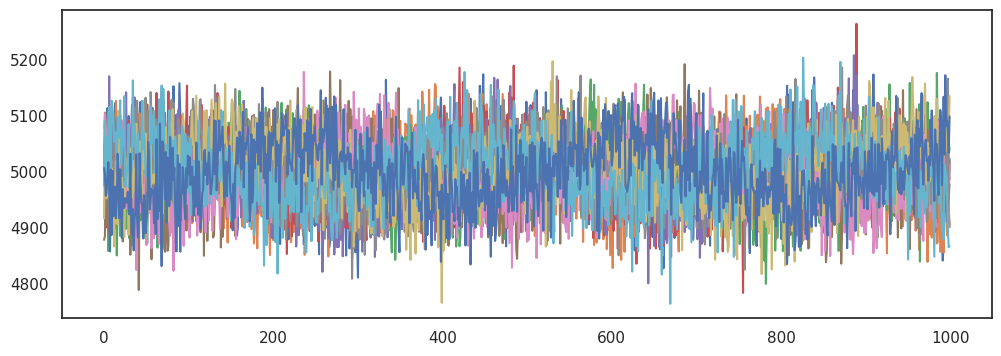

In [58]:
plt.figure(figsize=(12,4))
for a in range(11):
    plt.plot(assets[:1000,a])
plt.savefig('sinnoise', dpi = 200, transparent = True)

In [60]:
Lmodel = LModel(seq_len=50, batch_size=100)
data = DataModule_noval(input_len = 50, split= 0.7, batch_size = 100, assets = assets)

In [62]:
n_epochs = 500
trainer = L.Trainer(
                    devices = 1, accelerator = 'gpu',  max_epochs = n_epochs, log_every_n_steps=n_epochs//10, enable_progress_bar=True, callbacks=[EarlyStopping('val_loss', patience=15, mode='max'), ModelCheckpoint(dirpath = f'Noisy_periodic',filename='best_model', save_top_k=1, mode='max')])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [63]:
trainer.fit(Lmodel, data)
trainer.test(Lmodel, data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | Model | 2.1 K  | train
----------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 126: 100%|██████████| 34/34 [00:00<00:00, 45.77it/s, v_num=22]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 80.32it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_APV          │    3.9418201446533203     │
│        test_reward        │   0.013629535213112831    │
│        test_sharpe        │    1.1937551498413086     │
└───────────────────────────┴───────────────────────────┘

[{'test_reward': 0.013629535213112831,
  'test_APV': 3.9418201446533203,
  'test_sharpe': 1.1937551498413086}]

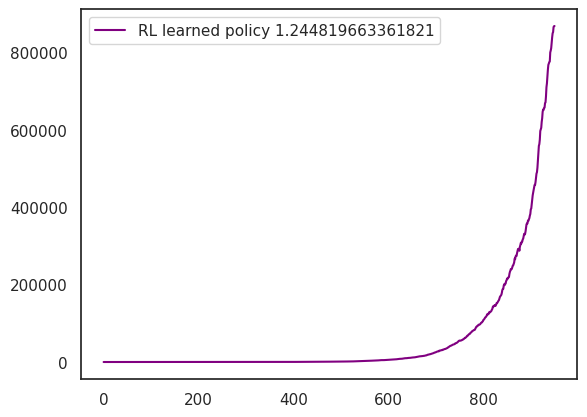

In [64]:
model = LModel.load_from_checkpoint('Noisy_periodic/best_model.ckpt')
data = assets
data = torch.tensor(data)
backtest = torch.permute(data, (2,1,0))
def backtest_by_strategy(data, strategy, seq_len, last_w = False):
    # lastw = torch.zeros((7))
    # lastw[0] = 1
    lastw = torch.ones((12))/12
    lastw = lastw.unsqueeze(0).to('cuda:0')
    log_mean =[]
    APV = [1]
    pvector = []
    w = []
    Y = []
    for i in range(1000-seq_len):
        x = data[:,:,i:i+seq_len]/ data[0,:,i+seq_len:i+seq_len+1].repeat((1,1,seq_len))
        y = (data[0,:,i+seq_len]/data[0,:,i+seq_len-1])
        y = torch.cat((torch.tensor([1]), y), dim = 0).to('cuda:0')
        if last_w:        
            new_w = strategy(x.unsqueeze(0).to('cuda:0'), lastw[:,1:].to('cuda:0'))
        else:
            new_w = strategy(x.unsqueeze(0).to('cuda:0').float())
        w.append(np.array(new_w.squeeze().cpu().detach()))
        Y.append(np.array(y.cpu().detach()))
        w_prime = (y * lastw).to('cuda:0')
        w_prime = w_prime/torch.sum(w_prime)
        c = 0.0
        mu = 1 - torch.sum(torch.abs(new_w - w_prime), dim=1) * c
        pv = torch.sum(new_w * y.to('cuda:0') * mu.to('cuda:0'))
        pvector.append(pv)
        log_mean.append(torch.mean(torch.log(torch.sum(new_w * y.to('cuda:0') * mu.to('cuda:0')))).item())
        APV.append(APV[-1]*torch.exp(torch.tensor(log_mean[-1])))
        lastw = new_w
    return APV, log_mean, torch.tensor(pvector), w, Y
model.eval()
APV, log_mean, pv, w, Y = backtest_by_strategy(backtest, model, model.seq_len, False)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'purple', label = f'RL learned policy {sharpe}')
plt.legend()

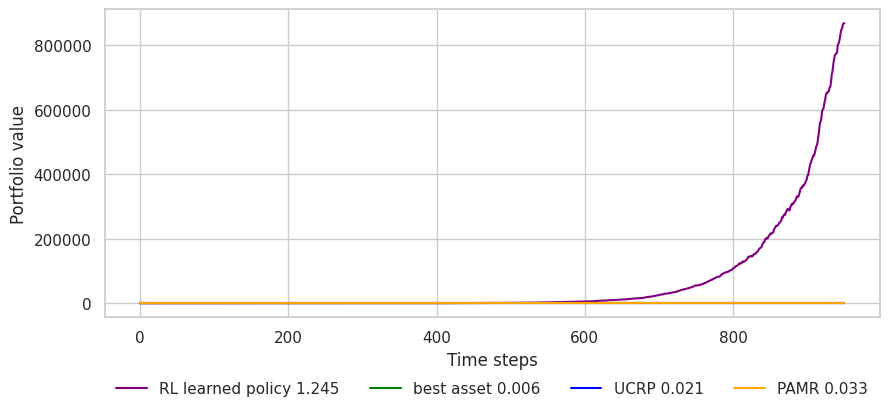

In [65]:
model.eval()
sns.set_style('whitegrid')
plt.figure(figsize=(10,4))
APV, log_mean, pv, w, _ = backtest_by_strategy(backtest, model, model.seq_len, False)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'purple', label = f'RL learned policy {sharpe:.3f}')
APV, log_mean, pv, _, _ = backtest_by_strategy(backtest, buy_and_hold(np.argmax(slopes) + 1), model.seq_len)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'green', label = f'best asset {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, UCRP(), model.seq_len)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'blue', label = f'UCRP {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, PAMR(0.95, 2, 0.5), model.seq_len, True)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'orange', label = f'PAMR {sharpe:.3f}')
plt.xlabel('Time steps')
plt.ylabel('Portfolio value')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 7, frameon = False)
plt.savefig('APV_plot_model',dpi = 300, transparent = True,  bbox_inches="tight")

/tmp/ipykernel_19755/1164225066.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


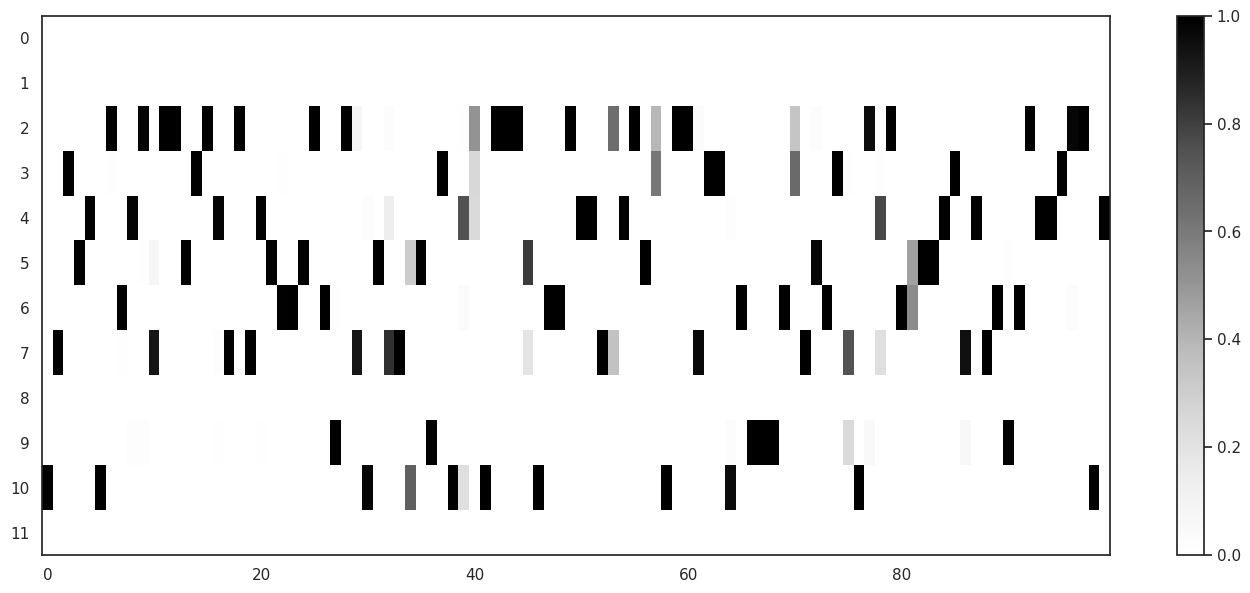

In [66]:
import matplotlib.gridspec as gridspec
sns.set_style('white')
fig = plt.figure(figsize = (20,7))
gs = gridspec.GridSpec(1, 2, width_ratios=[15, 2], wspace=0.05)
# Create second axes sharing the y-axis, positioned to the right
ax_matrix = fig.add_subplot(gs[0])
im = ax_matrix.imshow(np.array(w)[:100].T, cmap=plt.cm.Greys, aspect = 'auto')
plt.colorbar(im, ax = ax_matrix)

plt.yticks(range(12))
plt.tight_layout()

plt.savefig('weights_distrib_sin',dpi = 300, transparent = True)

> -  In periodic setting the model performance is dramatic : converges to a periodic reallocation
> -  almost all wallet value in asset going up at time t (predictable with seasonality)

#### Noisy Seasonal Trend <a class="anchor" id="2sub2sub3"></a>

In [2]:
N = 5000

season = lambda x : np.sin((np.arange(N)*2*x)/(20*np.pi)) * N/50+ N 
noise = lambda eps : np.random.normal(0, eps, N)
trend = lambda x : np.arange(N)*x

In [3]:
slopes = np.random.uniform(-0.5, 0.5, size = (11,))
temp = []
assets = []
for s in slopes:
    x = np.random.normal(0, 1)
    temp.append(x)
    asset = trend(s) + season(10*x) + noise(50)
    assets.append(asset)
assets = np.array(assets).T
assets = np.expand_dims(assets, axis = -1)

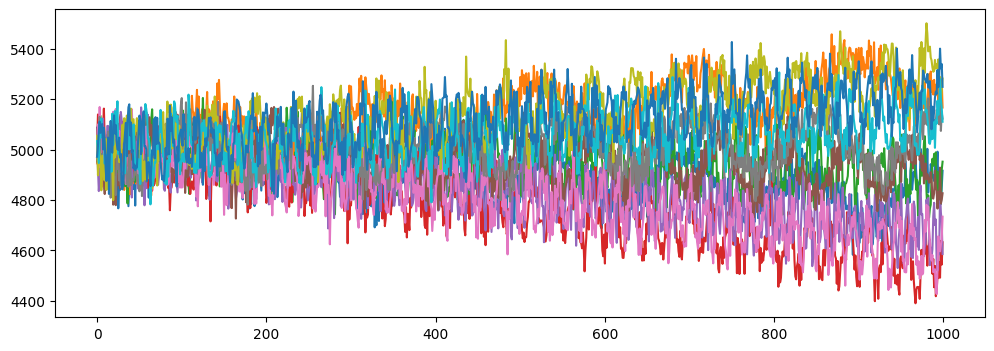

In [4]:
plt.figure(figsize = (12,4))
for a in range(11):
    plt.plot(assets[:1000,a])
plt.savefig('trendseason', dpi = 200, transparent = True)

In [71]:
Lmodel = LModel(seq_len=50, batch_size=100)
data = DataModule_noval(input_len = 50, split= 0.7, batch_size = 100, assets = assets)

In [72]:
n_epochs = 100

trainer = L.Trainer(
                    devices = 1, accelerator = 'gpu',  max_epochs = n_epochs, log_every_n_steps=n_epochs//10, enable_progress_bar=True, callbacks=[EarlyStopping('val_loss', patience=20, mode='max'),ModelCheckpoint(dirpath = f'Noisy_trendseasonal',filename='best_model', save_top_k=1, mode='max')])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [73]:
trainer.fit(Lmodel, data)
trainer.test(Lmodel, data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | Model | 2.1 K  | train
----------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 66: 100%|██████████| 34/34 [00:00<00:00, 45.04it/s, v_num=23]         


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 83.98it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_APV          │    1.4233349561691284     │
│        test_reward        │   0.003510524518787861    │
│        test_sharpe        │    0.33992841839790344    │
└───────────────────────────┴───────────────────────────┘

[{'test_reward': 0.003510524518787861,
  'test_APV': 1.4233349561691284,
  'test_sharpe': 0.33992841839790344}]

In [74]:
model = LModel.load_from_checkpoint('Noisy_trendseasonal/best_model.ckpt')
data = assets
data = torch.tensor(data)
backtest = torch.permute(data, (2,1,0))

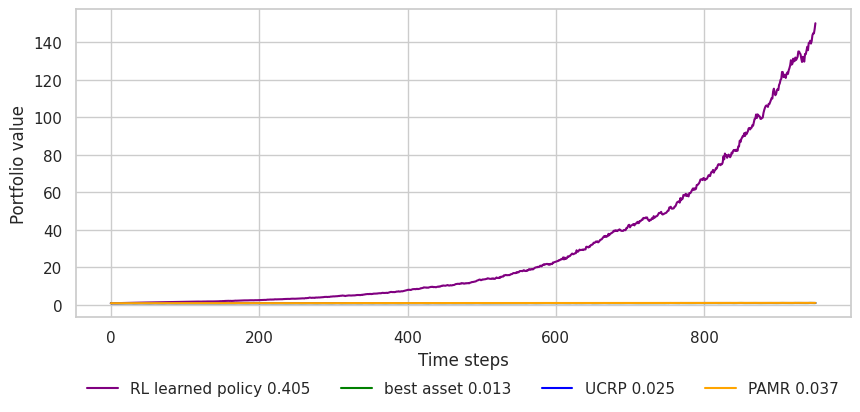

In [75]:
model.eval()
sns.set_style('whitegrid')
plt.figure(figsize=(10,4))
APV, log_mean, pv, w, _ = backtest_by_strategy(backtest, model, model.seq_len, False)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'purple', label = f'RL learned policy {sharpe:.3f}')
APV, log_mean, pv, _, _ = backtest_by_strategy(backtest, buy_and_hold(np.argmax(slopes) + 1), model.seq_len)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'green', label = f'best asset {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, UCRP(), model.seq_len)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'blue', label = f'UCRP {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, PAMR(0.95, 2, 0.5), model.seq_len, True)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'orange', label = f'PAMR {sharpe:.3f}')
plt.xlabel('Time steps')
plt.ylabel('Portfolio value')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 7, frameon = False)
plt.savefig('APV_plot_model',dpi = 300, transparent = True,  bbox_inches="tight")

/tmp/ipykernel_19755/2355721664.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


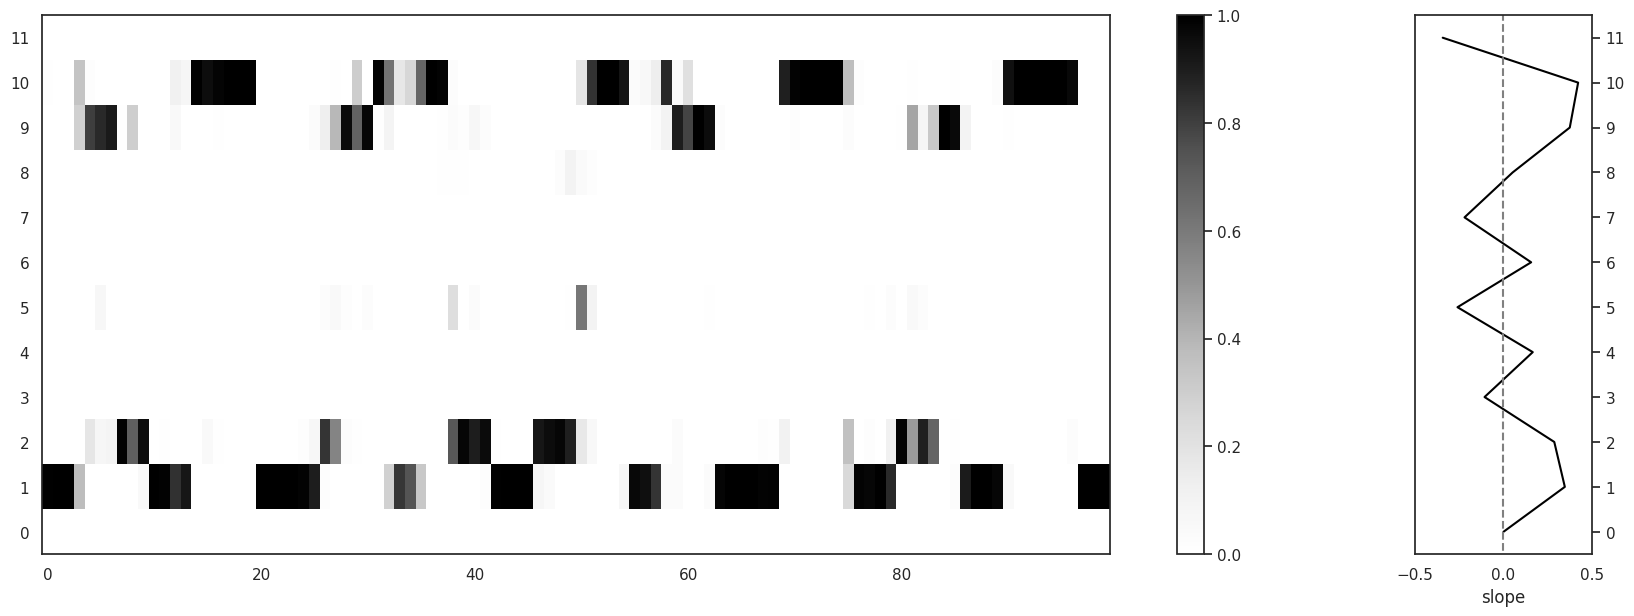

In [76]:
import matplotlib.gridspec as gridspec
sns.set_style('white')
fig = plt.figure(figsize = (20,7))
gs = gridspec.GridSpec(1, 2, width_ratios=[15, 2], wspace=0.05)
# Create second axes sharing the y-axis, positioned to the right
ax_matrix = fig.add_subplot(gs[0])
im = ax_matrix.imshow(np.array(w[:100]).T, cmap=plt.cm.Greys, aspect = 'auto')
plt.colorbar(im, ax = ax_matrix)

ax_curve = fig.add_subplot(gs[1], sharey=ax_matrix)
ax_curve.plot([0] + list(slopes), np.arange(np.array(w).shape[1]), color = 'black')

ax_curve.vlines(0, -2, 15, linestyles= '--', color ='grey')
ax_curve.set_ylim(-0.5,11.5)
ax_curve.set_xlim(-0.5,.5)
ax_curve.set_xlabel("Mean Value")
ax_curve.yaxis.tick_right()
ax_curve.yaxis.set_label_position("right")
ax_curve.set_xlabel('slope')
plt.yticks(range(12))
plt.tight_layout()

plt.savefig('weights_distrib_noise10_lr3',dpi = 300, transparent = True)

> - In seasonal +trend case  the model converges to reallocating periodically depending on signal phase 
> - Compared to seasonal only we see the model favors assets with the highest slope 
> - Model can still pick out trend on top of seasonal + residual effects

### 2.3 Model Training and Evaluation <a class="anchor" id="2sub3"></a>

In [2]:
df_all = pd.read_parquet('./data/df_all.parquet').iloc[:,:]
data = df_all.values.reshape(-1, 8,3)
data = torch.tensor(data)
data = torch.permute(data, (2,1,0))

#### Model Training <a class="anchor" id="2sub3sub1"></a>

The main script for training the model is *Run_RL.py* with the NBEATS architecture in *NBEATS.py*

Argparse allows for CLI control over training parameters :
- Train CNN or NBEATS
- Train w or w/o transacation fees
- set learning objective (return or sharpe ratio)
- training conditions ( patience for early stopping, val split...)

In [ ]:
# %run 'Run_RL.py'  --logger 0 --start_index 77000  --samples 15000 --loss 'return' --training mapping

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/jovyan/cloned_gits/RL_project/2024-05-24_RL_run_mapping_NBEATS exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | NBEATS | 2.5 M  | train
-----------------------------------------
2.5 M     Trainable params
260       Non-trainable params
2.5 M     Total params
9.897     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 10: 100%|██████████| 208/208 [00:04<00:00, 45.77it/s, v_num=30]      

Restoring states from the checkpoint path at /home/jovyan/cloned_gits/RL_project/2024-05-24_RL_run_mapping_NBEATS/best_model-v1.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/jovyan/cloned_gits/RL_project/2024-05-24_RL_run_mapping_NBEATS/best_model-v1.ckpt


Testing DataLoader 0: 100%|██████████| 43/43 [00:00<00:00, 109.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_APV          │    0.9980691075325012     │
│        test_reward        │   -4.36475093010813e-05   │
│        test_sharpe        │   -0.018907131627202034   │
└───────────────────────────┴───────────────────────────┘

#### Benchmark and Backtest preparation <a class="anchor" id="2sub3sub2"></a>

In [52]:
def max_drawdown(pc_array):
    """calculate the max drawdown with the portfolio changes
    @:param pc_array: all the portfolio changes during a trading process
    @:return: max drawdown
    """
    portfolio_values = []
    drawdown_list = []
    max_benefit = 0
    for i in range(pc_array.shape[0]):
        if i > 0:
            portfolio_values.append(portfolio_values[i - 1] * pc_array[i])
        else:
            portfolio_values.append(pc_array[i])
        if portfolio_values[i] > max_benefit:
            max_benefit = portfolio_values[i]
            drawdown_list.append(0.0)
        else:
            drawdown_list.append(1.0 - portfolio_values[i] / max_benefit)
    return max(drawdown_list)


def moving_accumulate(pc_array, n=48):
    acc = np.cumprod(pc_array)
    acc[n:] = acc[n:] / acc[:-n]
    return acc


def positive_count(pc_array):
    return np.sum(pc_array>1)


def negative_count(pc_array):
    return np.sum(pc_array<1)

def backtest_by_strategy(data, strategy, seq_len, last_w = False, fee = 0):
    # lastw = torch.zeros((7))
    # lastw[0] = 1
    lastw = torch.ones((9))/9
    lastw = lastw.unsqueeze(0).to('cuda:0')
    log_mean =[]
    APV = [1]
    pvector = []
    w = []
    Y = []
    for i in range(data.shape[-1]-seq_len):
        x = data[:,:,i:i+seq_len]
        y = (data[0,:,i+seq_len]/data[0,:,i+seq_len-1])
        y = torch.cat((torch.tensor([1]), y), dim = 0).to('cuda:0')
        if last_w:        
            new_w = strategy(x.unsqueeze(0).to('cuda:0'), lastw[:,1:].to('cuda:0'))
        else:
            new_w = strategy(x.unsqueeze(0).to('cuda:0').float())
        w.append(np.array(new_w.squeeze().cpu().detach()))
        Y.append(np.array(y.cpu().detach()))
        w_prime = (y * lastw).to('cuda:0')
        w_prime = w_prime/torch.sum(w_prime)
        c = fee
        mu = 1 - torch.sum(torch.abs(new_w - w_prime), dim=1) * c
        pv = torch.sum(new_w * y.to('cuda:0') * mu.to('cuda:0'))
        pvector.append(pv)
        log_mean.append(torch.mean(torch.log(torch.sum(new_w * y.to('cuda:0') * mu.to('cuda:0')))).item())
        APV.append(APV[-1]*torch.exp(torch.tensor(log_mean[-1])))
        lastw = new_w
    return APV, log_mean, torch.tensor(pvector), w, Y

In [53]:
def simplex_proj(y):
    '''projection of y onto simplex. '''
    m = len(y)
    bget = False

    s = torch.sort(y, descending = True)[0]
    tmpsum = 0.

    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1)
        if tmax >= s[ii+1]:
            bget = True
            break

    if not bget:
        tmax = (tmpsum + s[m-1] - 1) / m

    return torch.maximum(torch.tensor(0), y-tmax)

## Define strategies
class buy_and_hold():
    def __init__(self, n):
        self.n = n
    def __call__(self, x, lastw = None):
        new_w = torch.zeros((9)).to('cuda:0')
        new_w[self.n] = 1
        return new_w.unsqueeze(0)

class UCRP():
    def __init__(self):
        pass
    
    def __call__(self, x, lastw = None):
        new_w = torch.ones((9)).to('cuda:0')
        new_w = new_w/torch.sum(new_w)
        return new_w.unsqueeze(0)

class PAMR():
    def __init__(self, epsilon, variant, C):
        self.epsilon = epsilon
        self.C = torch.tensor(C)
        self.variant = variant

    def __call__(self, x, lastw):
        last_rel_price = x[0,-1,:,-1]/x[0,-1,:,-2]
        last_rel_price = torch.cat((torch.tensor([1]).to('cuda:0'), last_rel_price), dim = 0)
        lastw = torch.cat((torch.tensor([1-torch.sum(lastw)]).to('cuda:0'), lastw.squeeze()), dim = 0)

        denom = torch.square(torch.norm(last_rel_price-torch.mean(last_rel_price)))
        diff = torch.dot(lastw.float(), last_rel_price.squeeze().float())- self.epsilon
        le = torch.maximum(torch.tensor(0), diff)

        if self.variant == 0:
            tau = le / denom
        elif self.variant == 1:
            tau = torch.minimum(self.C, le / denom)
        elif self.variant == 2:
            tau = le / (denom + 0.5 / self.C)
            
        tau = torch.minimum(torch.tensor(10000), tau)

        new_w = lastw - tau * (last_rel_price - torch.mean(last_rel_price))
        return simplex_proj(new_w).unsqueeze(0)
    
class OLMAR():
    """On-Line Portfolio Selection with Moving Average Reversion

    Reference:
        B. Li and S. C. H. Hoi.
        On-line portfolio selection with moving average reversion, 2012.
        http://icml.cc/2012/papers/168.pdf
    """

    def __init__(self, window=50, eps=10, alpha=0.5, ma_type="SMA"):
        """
        :param window: Lookback window.
        :param eps: Constraint on return for new weights on last price (average of prices).
            x * w >= eps for new weights w.
        :param alpha: Decaying factor for using EMA as price relative prediction
        :param ma_type: Type of moving average used, either SMA or EMA
        """

        self.min_history =  0
        self.frequency = 1

        # input check
        if window < 2:
            raise ValueError("window parameter must be >=3")
        if eps < 1:
            raise ValueError("epsilon parameter must be >=1")
        if ma_type not in ["SMA", "EMA"]:
            raise ValueError('ma_type should be either "SMA" or "EMA"')

        self.window = window
        self.eps = eps
        self.alpha = alpha
        self.ma_type = ma_type

    def init_weights(self, columns):
        m = len(columns)
        return np.ones(m) / m

    def init_step(self, X):
        # self.x_pred = X.iloc[1, :] / X.iloc[0, :]
        self.x_pred = X.iloc[0, :]

    def step(self, x, last_b, history):
        # calculate return prediction
        if len(history) < self.window + 1:
            x_pred = history.iloc[-1]
        else:
            x_pred = self.predict(x, history.iloc[-self.window :])
        b = self.update(last_b, x_pred, self.eps)
        return b

    def predict(self, x, hist):
        """Predict next price relative."""
        if self.ma_type == "SMA":
            return hist.mean() / hist.iloc[-1, :]
        else:
            real_x = hist.iloc[-1, :] / hist.iloc[-2, :]
            x_pred = self.alpha + (1 - self.alpha) * np.divide(self.x_pred, real_x)
            self.x_pred = x_pred
            return x_pred

    def update(self, b, x_pred, eps):
        """Update portfolio weights to satisfy constraint b * x >= eps
        and minimize distance to previous weights."""
        x_pred_mean = np.mean(x_pred)
        excess_return = x_pred - x_pred_mean
        denominator = (excess_return * excess_return).sum()
        if denominator != 0:
            lam = max(0.0, (eps - np.dot(b, x_pred)) / denominator)
        else:
            lam = 0

        # update portfolio
        b = b + lam * (excess_return)

        # project it onto simplex
        return simplex_proj(b)
    
    def __call__(self, x, b, eps = 10):
        eps = self.eps
        hist = torch.permute(x[0,0,:,:], (1,0))
        x_pred = hist.mean(dim = 0) / hist[-1, :]
        x_pred = torch.cat((torch.tensor([1]).to('cuda:0'), x_pred), dim = 0)
        b = torch.cat((torch.tensor([1-torch.sum(b)]).to('cuda:0'), b.squeeze()), dim = 0)
        x_pred = x_pred.float()
        x_pred_mean = torch.mean(x_pred)
        excess_return = x_pred - x_pred_mean
        denominator = (excess_return * excess_return).sum()
        if denominator != 0:
            lam = max(0.0, (eps - torch.dot(b, x_pred)) / denominator)
        else:
            lam = 0

        # update portfolio
        b = b + lam * (excess_return)

        # project it onto simplex
        return simplex_proj(b).unsqueeze(0)
        

#### Model Evaluation <a class="anchor" id="2sub3sub3"></a>

Evaluate model on most recent data 

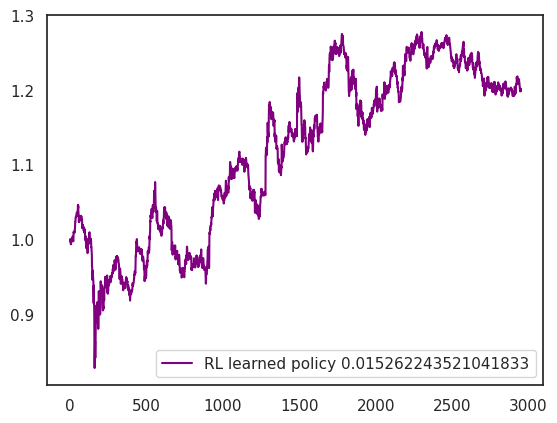

In [7]:
df_all = pd.read_parquet('./data/df_all.parquet').iloc[:,:]
data = df_all.values.reshape(-1, 8,3)
data = torch.tensor(data)
data = torch.permute(data, (2,1,0))
## Check NBEATS vs CNN 

final_path = f'2024-05-24_RL_run_mapping_NBEATS/best_model.ckpt'
# runid = mlflow.search_runs(experiment_ids=[2815], filter_string='tags.mlflow.runName = "RL_run_mapping_NBEATS"')['run_id'][0]
# path = f'./2815/{runid}/checkpoints/'
# final_path = path + os.listdir(path)[0]

model = LModel.load_from_checkpoint(final_path)
model.eval()
APV, log_mean, pv, w, Y = backtest_by_strategy(data[:,:, 92000-3000:92000], model, model.seq_len, False)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'purple', label = f'RL learned policy {sharpe}')
plt.legend()
model_nofees = model

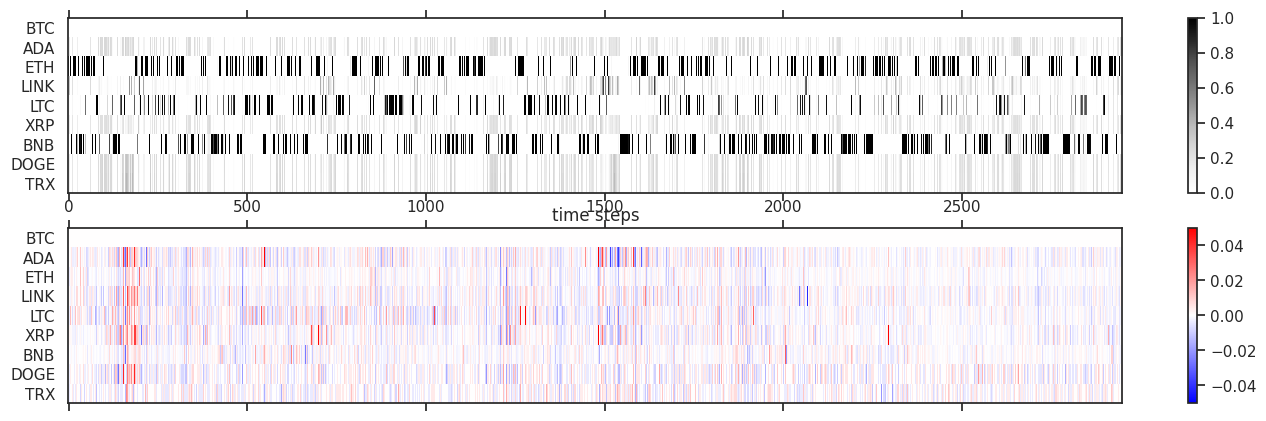

In [8]:
sns.set_style('white')
fig, axs = plt.subplots(2,1,figsize=(17,5), sharex = True)
img0 = axs[0].matshow(np.array(w)[:].T, cmap=plt.cm.Greys, aspect = 'auto')
axs[0].set_xlabel('time steps')
axs[0].set_yticks(range(9),['BTC']+Coinlist)

img1 = axs[1].matshow(np.array(Y)[:].T - 1, cmap=plt.cm.bwr, aspect = 'auto', vmin = -0.05, vmax = 0.05 )
axs[1].set_yticks(range(9),['BTC']+ Coinlist)
plt.colorbar(img0)
plt.colorbar(img1)
plt.savefig('transaction_fees_w', transparent = True)

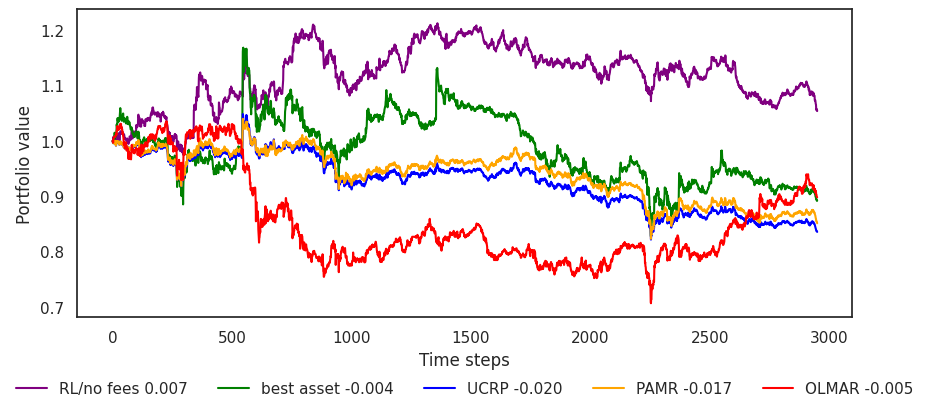

In [ ]:
backtest = data[:,:,-3000:]
model.eval()
sns.set_style('white')
plt.figure(figsize=(10,4))
APV, log_mean, pv, w, _ = backtest_by_strategy(backtest, model, model.seq_len, False)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'purple', label = f'RL/no fees {sharpe:.3f}')
# APV, log_mean, pv, w, _ = backtest_by_strategy(backtest, model_fees, model.seq_len, True)
# sharpe = (torch.mean(pv)-1)/torch.std(pv)
# plt.plot(APV, color = 'grey', label = f'RL/fees {sharpe:.3f}')
APV, log_mean, pv, _, _ = backtest_by_strategy(backtest, buy_and_hold(5), model.seq_len)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'green', label = f'best asset {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, UCRP(), model.seq_len)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'blue', label = f'UCRP {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, PAMR(0.5, 2, 0.3), model.seq_len, True)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'orange', label = f'PAMR {sharpe:.3f}')
APV, log_mean, pv, wolmar,_ = backtest_by_strategy(backtest, OLMAR(50, eps = 10), model.seq_len, True)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'red', label = f'OLMAR {sharpe:.3f}')
plt.xlabel('Time steps')
plt.ylabel('Portfolio value')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 7, frameon = False)
plt.savefig('APV_plot_model',dpi = 300, transparent = True,  bbox_inches="tight")

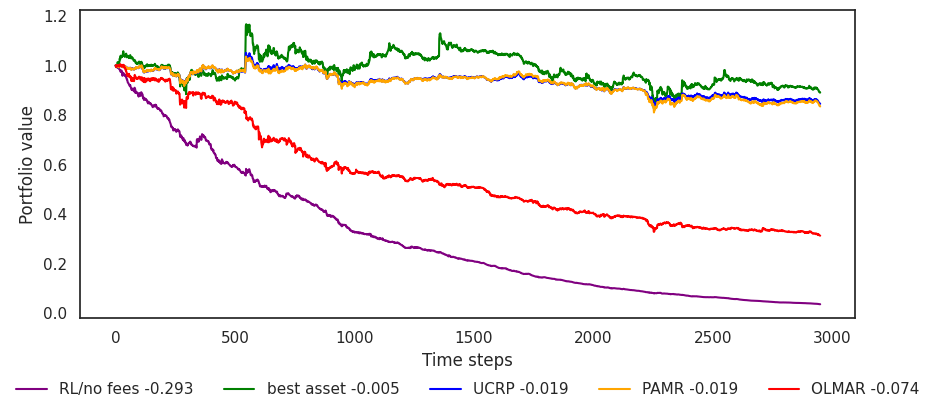

In [15]:
backtest = data[:,:,-3000:]
model.eval()
sns.set_style('white')
plt.figure(figsize=(10,4))
APV, log_mean, pv, w, _ = backtest_by_strategy(backtest, model, model.seq_len, False,  fee = 0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'purple', label = f'RL/no fees {sharpe:.3f}')
# APV, log_mean, pv, w, _ = backtest_by_strategy(backtest, model_fees, model.seq_len, True)
# sharpe = (torch.mean(pv)-1)/torch.std(pv)
# plt.plot(APV, color = 'grey', label = f'RL/fees {sharpe:.3f}')
APV, log_mean, pv, _, _ = backtest_by_strategy(backtest, buy_and_hold(5), model.seq_len,  fee = 0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'green', label = f'best asset {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, UCRP(), model.seq_len,  fee = 0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'blue', label = f'UCRP {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, PAMR(0.5, 2, 0.3), model.seq_len, True,  fee = 0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'orange', label = f'PAMR {sharpe:.3f}')
APV, log_mean, pv, wolmar,_ = backtest_by_strategy(backtest, OLMAR(50, eps = 10), model.seq_len, True,  fee = 0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'red', label = f'OLMAR {sharpe:.3f}')
plt.xlabel('Time steps')
plt.ylabel('Portfolio value')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 7, frameon = False)
plt.savefig('APV_plot_model_fees',dpi = 300, transparent = True,  bbox_inches="tight")

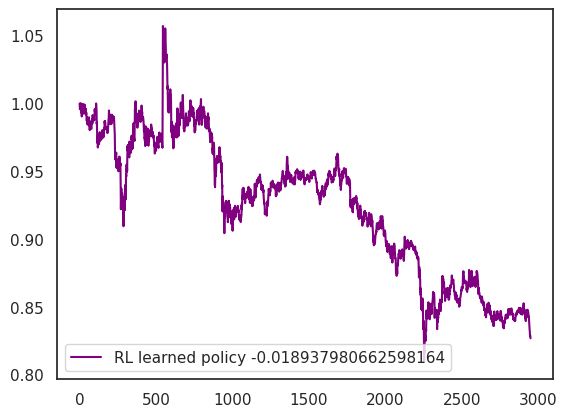

In [ ]:
## Check NBEATS vs CNN 
from Run_RL import TraderTrainer
final_path = './2024-05-24_RL_run_buffer_NBEATS/best_model.ckpt'

model = TraderTrainer.load_from_checkpoint(final_path)
model.eval()
APV, log_mean, pv, w, Y = backtest_by_strategy(data[:,:, -3000:], model, model.seq_len, True, fee=0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'purple', label = f'RL learned policy {sharpe}')
plt.legend()
model_nofees = model

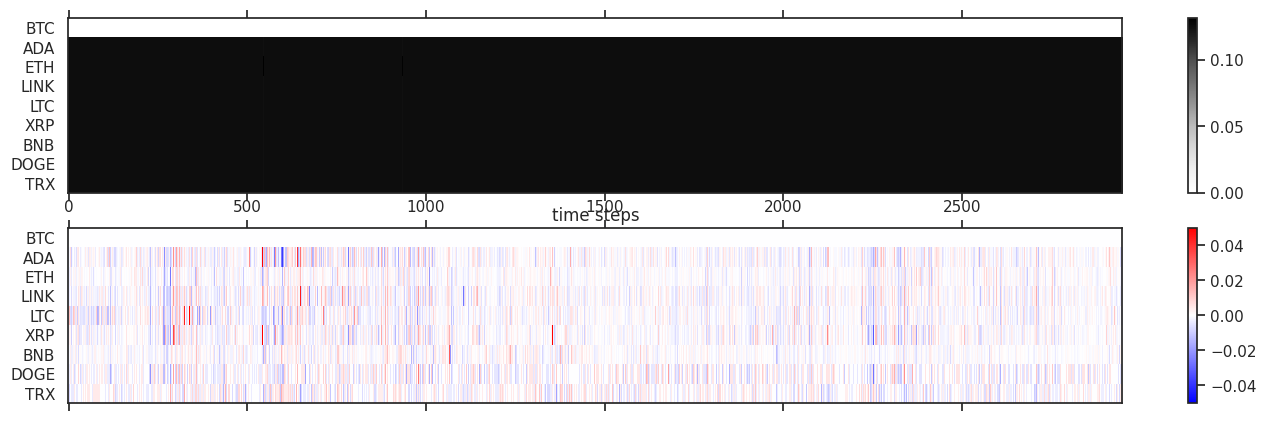

In [64]:
sns.set_style('white')
fig, axs = plt.subplots(2,1,figsize=(17,5), sharex = True)
img0 = axs[0].matshow(np.array(w)[:,:].T, cmap=plt.cm.Greys, aspect = 'auto')
axs[0].set_xlabel('time steps')
axs[0].set_yticks(range(9),['BTC']+Coinlist)

img1 = axs[1].matshow(np.array(Y)[:].T - 1, cmap=plt.cm.bwr, aspect = 'auto', vmin = -0.05, vmax = 0.05 )
axs[1].set_yticks(range(9),['BTC']+ Coinlist)
plt.colorbar(img0)
plt.colorbar(img1)
plt.savefig('transaction_fees_w', transparent = True)

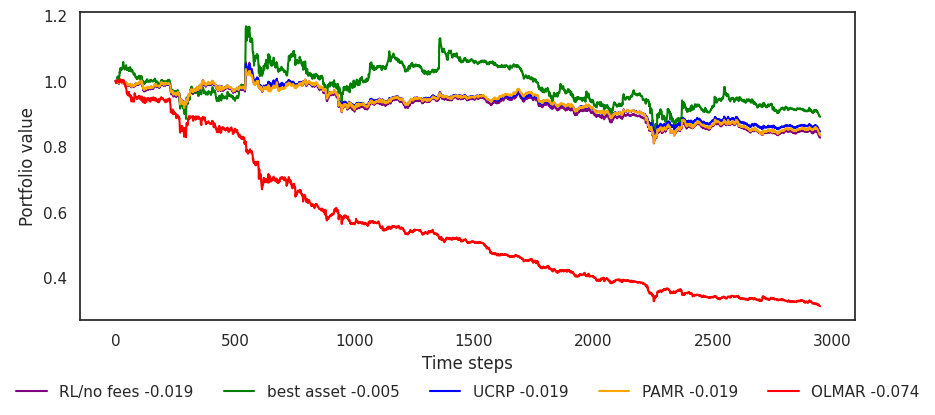

In [65]:
backtest = data[:,:,-3000:]
model.eval()
sns.set_style('white')
plt.figure(figsize=(10,4))
APV, log_mean, pv, w, _ = backtest_by_strategy(backtest, model, model.seq_len, True,  fee = 0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'purple', label = f'RL/no fees {sharpe:.3f}')
# APV, log_mean, pv, w, _ = backtest_by_strategy(backtest, model_fees, model.seq_len, True)
# sharpe = (torch.mean(pv)-1)/torch.std(pv)
# plt.plot(APV, color = 'grey', label = f'RL/fees {sharpe:.3f}')
APV, log_mean, pv, _, _ = backtest_by_strategy(backtest, buy_and_hold(5), model.seq_len,  fee = 0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'green', label = f'best asset {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, UCRP(), model.seq_len,  fee = 0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'blue', label = f'UCRP {sharpe:.3f}')
APV, log_mean, pv, _,_ = backtest_by_strategy(backtest, PAMR(0.5, 2, 0.3), model.seq_len, True,  fee = 0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'orange', label = f'PAMR {sharpe:.3f}')
APV, log_mean, pv, wolmar,_ = backtest_by_strategy(backtest, OLMAR(50, eps = 10), model.seq_len, True,  fee = 0.001)
sharpe = (torch.mean(pv)-1)/torch.std(pv)
plt.plot(APV, color = 'red', label = f'OLMAR {sharpe:.3f}')
plt.xlabel('Time steps')
plt.ylabel('Portfolio value')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol = 7, frameon = False)
plt.savefig('APV_plot_model_fees',dpi = 300, transparent = True,  bbox_inches="tight")

#### Test TS training <a class="anchor" id="2sub3sub4"></a>

In [180]:
from Run_TS import LModel

final_path = f'2024-05-24_TS_run_NBEATS/best_model.ckpt'
model = LModel.load_from_checkpoint(final_path)

In [81]:
def backtest_by_strategy2(data, strategy, seq_len, last_w = False, fee = 0, mult = 1):
    # lastw = torch.zeros((7))
    # lastw[0] = 1
    lastw = torch.ones((9))/9
    lastw = lastw.unsqueeze(0).to('cuda:0')
    log_mean =[]
    APV = [1]
    pvector = []
    w = []
    Y = []
    for i in range(data.shape[-1]-seq_len):
        x = data[:,:,i:i+seq_len]
        y = (data[0,:,i+seq_len]/data[0,:,i+seq_len-1])
        y = torch.cat((torch.tensor([1]), y), dim = 0).to('cuda:0')
        if last_w:        
            new_w = strategy(x.unsqueeze(0).to('cuda:0'), lastw[:,1:].to('cuda:0'))
        else:
            new_w = strategy(x.unsqueeze(0).to('cuda:0').float())
        w.append(np.array(simplex_proj(mult*new_w.squeeze().cpu().detach())))
        Y.append(np.array(y.cpu().detach()))
        new_w = torch.concatenate((torch.zeros((1,1)).to('cuda:0'), simplex_proj(mult*new_w.squeeze()).unsqueeze(0)), dim = 1)
        w_prime = (y * lastw).to('cuda:0')
        w_prime = w_prime/torch.sum(w_prime)
        c = fee
        mu = 1 - torch.sum(torch.abs(new_w - w_prime), dim=1) * c
        pv = torch.sum(new_w * y.to('cuda:0') * mu.to('cuda:0'))
        pvector.append(pv)
        log_mean.append(torch.mean(torch.log(torch.sum(new_w * y.to('cuda:0') * mu.to('cuda:0')))).item())
        APV.append(APV[-1]*torch.exp(torch.tensor(log_mean[-1])))
        lastw = new_w
    return APV, log_mean, torch.tensor(pvector), w, Y

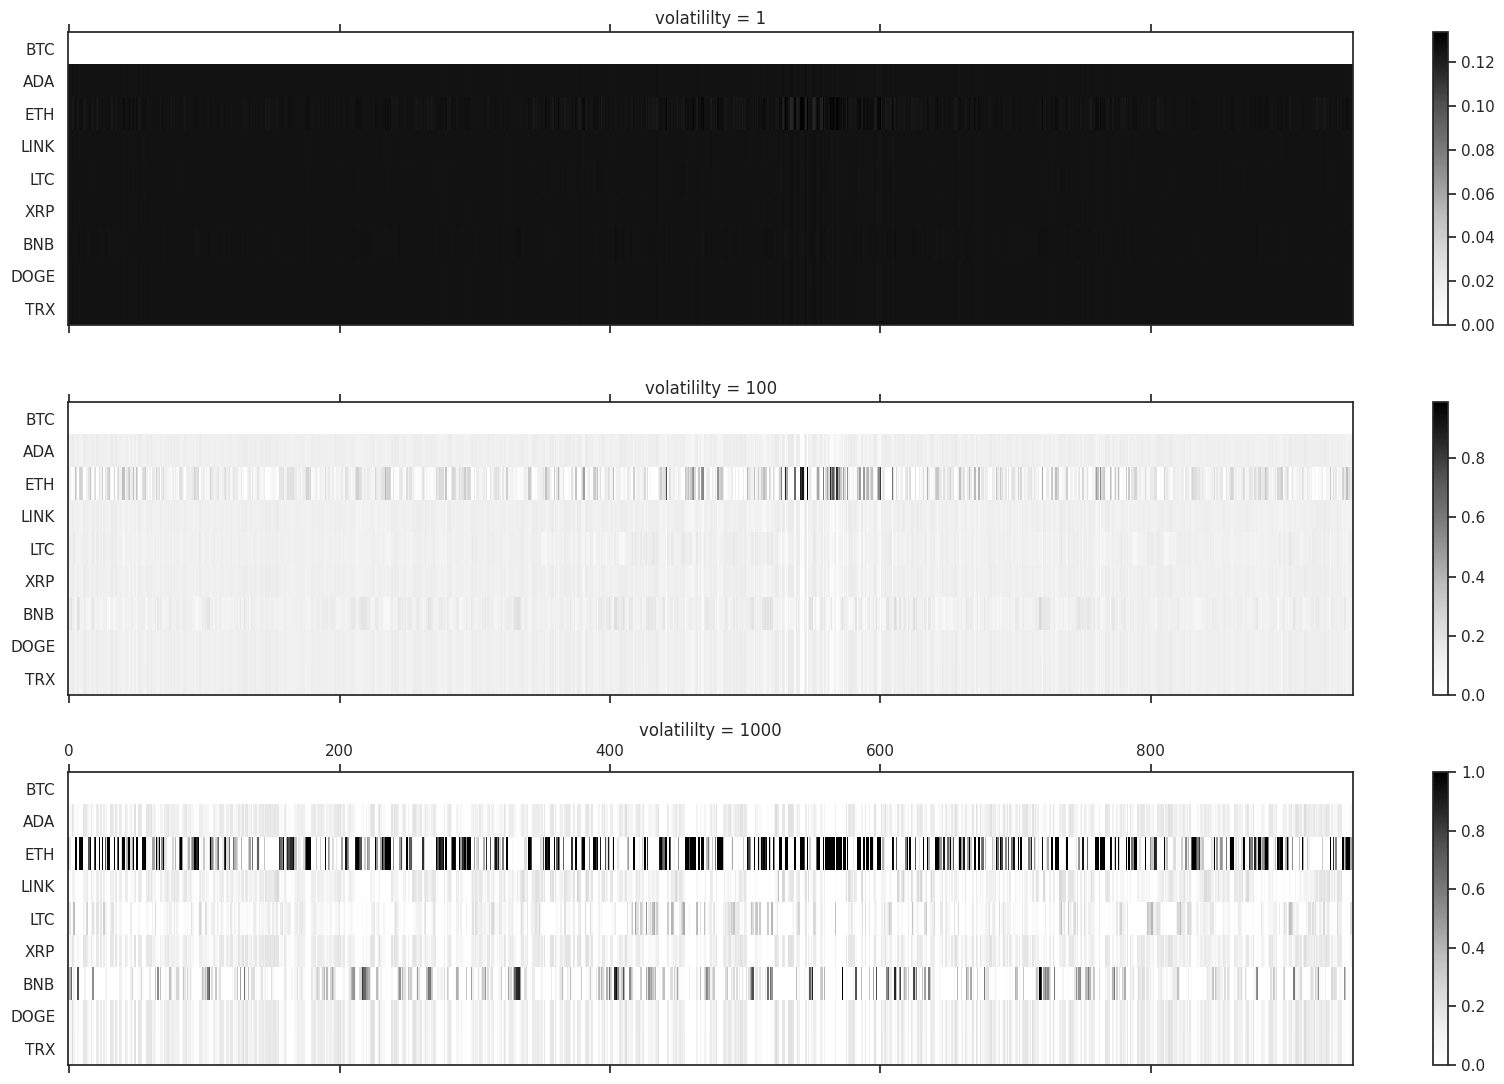

In [93]:
APV, log_mean, pv, w1, _ = backtest_by_strategy2(backtest, model, model.seq_len, False,  fee = 0.001, mult = 1)
APV, log_mean, pv, w2, _ = backtest_by_strategy2(backtest, model, model.seq_len, False,  fee = 0.001, mult = 100)
APV, log_mean, pv, w3, _ = backtest_by_strategy2(backtest, model, model.seq_len, False,  fee = 0.001, mult = 1000)
sns.set_style('white')
fig, axs = plt.subplots(3,1,figsize=(17,11), sharex = True)
img0 = axs[0].matshow(np.concatenate((np.zeros((1,950)),np.array(w1)[:].T),axis = 0), cmap=plt.cm.Greys, aspect = 'auto')
axs[0].set_yticks(range(9),['BTC']+Coinlist)

img1 = axs[1].matshow(np.concatenate((np.zeros((1,950)),np.array(w2)[:].T),axis = 0), cmap=plt.cm.Greys, aspect = 'auto')
axs[1].set_yticks(range(9),['BTC']+ Coinlist)
plt.colorbar(img0)
plt.colorbar(img1)
plt.savefig('transaction_fees_w', transparent = True)
img2 = axs[2].matshow(np.concatenate((np.zeros((1,950)),np.array(w3)[:].T),axis = 0), cmap=plt.cm.Greys, aspect = 'auto')
axs[2].set_yticks(range(9),['BTC']+ Coinlist)
plt.colorbar(img2)
axs[0].set_title('volatililty = 1')
axs[1].set_title('volatililty = 100')
axs[2].set_title('volatililty = 1000')
fig.tight_layout()
plt.savefig('transaction_fees_w', transparent = True)

#### Test Initial Assumptions <a class="anchor" id="2sub3sub5"></a>

In [98]:
df = pd.DataFrame(y, columns = ['BTC']+Coinlist )

In [103]:
df = df_all.iloc[-15000:, ::3]

In [109]:
df = df / df.shift(1)
df = df.dropna()

In [111]:
df[df == 1].sum(axis = 0)/len(df.index)

ADABTC     0.159944
ETHBTC     0.057070
LINKBTC    0.059471
LTCBTC     0.111807
XRPBTC     0.109074
BNBBTC     0.026468
DOGEBTC    0.360491
TRXBTC     0.400760
dtype: float64

In [148]:
df_vol = pd.read_csv('20250528 Request Data/data_volume.csv')
df_close = pd.read_csv('20250528 Request Data/data_close.csv')

In [ ]:
df_vol = df_vol.drop(columns=['SOLBTC'])
for coin in Coinlist :
    df_vol[f'{coin}BTC']=df_vol[f'{coin}BTC']*df_close[f'{coin}BTC']*df_close['BTCUSDT']

In [179]:
for coin in Coinlist :
    print(f'{coin} mean:',df_vol[f'{coin}BTC'][-15000:].mean())
    print(f'{coin} median:',df_vol[f'{coin}BTC'][-15000:].median())

ADA mean: 151004.45581989715
ADA median: 39424.07497796366
ETH mean: 2120381.069664868
ETH median: 1169886.1902586697
LINK mean: 81621.0947935585
LINK median: 31646.476358469852
LTC mean: 115926.91215419848
LTC median: 64006.024453259015
XRP mean: 717887.3102948853
XRP median: 218843.09880462915
BNB mean: 402777.82368765946
BNB median: 231924.2007334582
DOGE mean: 451477.206140589
DOGE median: 73114.12243771259
TRX mean: 87666.94249320876
TRX median: 34205.1443339032
